## Homework #5. Behaviour exploration improvement
##### Author: `Yuliia Stoliaruk`
##### Total time spent on h/w (in minutes): `1800`

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import ast
from datetime import datetime, date
from ast import literal_eval
import re
from langdetect import detect
import plotly.express as px
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import emoji

In [3]:
DIALOGS_MERGED_DATA_PATH = "D:/css/telegram-data-collection-master/data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "D:/css/telegram-data-collection-master/data/merged_data/dialogs_users_all.csv"

In [4]:
my_id = '770605699'

In [5]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

### Data Cleaning

In [6]:
df.rename(columns={'date': 'timestamp'}, inplace=True)
to_date = lambda s: datetime.strptime(s, '%Y-%m-%d %H:%M:%S+00:00')
df['timestamp'] = df['timestamp'].apply(to_date)
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['hour'] = df['timestamp'].dt.hour
df['year_month'] = df['timestamp'].dt.to_period('M')

Сlean column 'fwd_from'

In [7]:
def extract_id_and_source(s):
    pattern = re.compile(r"from_id=([^,]+),")
    match = pattern.search(s)

    if match is None:
        return (float('nan'), None)

    from_id = match.group(1)

    if "PeerUser" in from_id:
        source = "User"
        from_id = re.search(r"user_id=(\d+)", from_id).group(1)
    elif "PeerChannel" in from_id:
        source = "Channel"
        from_id = re.search(r"channel_id=(\d+)", from_id).group(1)
    else:
        source = "Unknown"

    return (from_id, source)

# Function to extract 'fwd_from_id' and 'fwd_from_source'
def extract_and_assign(row):
    from_id, source = extract_id_and_source(str(row['fwd_from']))
    return pd.Series({'fwd_from': from_id, 'fwd_from_source': source})


In [8]:
df[['fwd_from', 'fwd_from_source']] = df.apply(lambda row: extract_and_assign(row), axis=1)

Clean from_id column

In [9]:
def extract_user_id(s) -> str:
    pattern = re.compile("PeerUser\(user_id=(?P<user_id>.*?)\)", re.VERBOSE)
    match = pattern.match(str(s))

    if match is None:
        return 'nan'

    return match.group("user_id")


In [10]:
df['from_id'] = df['from_id'].apply(extract_user_id)
df.loc[df['from_id'] == 'nan', 'from_id'] = df.loc[df['from_id'] == 'nan', 'dialog_id']
df['from_id'] = df['from_id'].apply(str)

In [42]:
df['from_id'].iloc[100000]

'475253228'

Create new column 'type' with types of dialog.

In [11]:
dialog_ids = df.dialog_id.unique()

private_dialog_ids = df_meta[df_meta['type'] == 'Private dialog'].dialog_id.unique()
group_ids = df_meta[df_meta['type'] == 'Group'].dialog_id.unique()
channel_ids = np.setdiff1d(dialog_ids, np.concatenate((group_ids, private_dialog_ids)))

In [12]:
df_types_dialog = pd.DataFrame({'Type': ['Private', 'Group', 'Channel'], 'Amount': [private_dialog_ids.size, group_ids.size, channel_ids.size]})
df_types_dialog

,Type,Amount
0,Private,91
1,Group,70
2,Channel,50


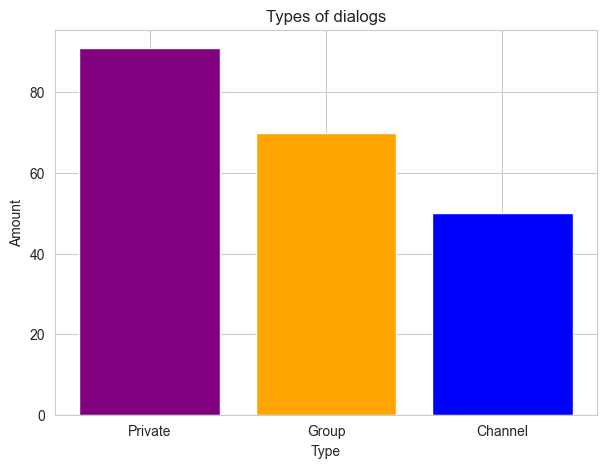

In [13]:
plt.figure(figsize=(7, 5))
plt.bar(df_types_dialog['Type'], df_types_dialog['Amount'], color = ['purple', 'orange', 'blue'])
plt.xlabel('Type')
plt.ylabel('Amount')
plt.title("Types of dialogs")
plt.show()

In [14]:
df['dialog_type'] = np.select(
    [df['dialog_id'].isin(private_dialog_ids), df['dialog_id'].isin(group_ids)],
    ['Dialog', 'Group'], # Values to select if conditions are met
    default='Channel' # Default value if none of the conditions are met
)

Detect language of the messages and save it to new column 'language'

In [15]:
df['message'] = df['message'].astype(str)
df['language'] = 'Unknown'
for i in range(df.shape[0]-1):
    try:
        df['language'].iloc[i] = detect(df['message'].iloc[i])
    except:
        df['language'].iloc[i] = 'Unknown'

Clean meassages from unnecesary words and symbols

List of ukrainian stopwords you could find in this repo: https://github.com/skupriienko/Ukrainian-Stopwords

In [16]:
stopwords_ua = pd.read_csv("stopwords_ua.txt", header=None, names=['stopwords'])
stop_words_ua = list(stopwords_ua.stopwords)


stop_words_en = set(stopwords.words("english"))
stop_words_ru = set(stopwords.words("russian"))
stop_words = stop_words_en.union(stop_words_ru)
stop_words = stop_words.union({'nan'})

In [17]:
def remove_small_letter_words(data):
    words = word_tokenize(data)

    new_text = ""
    for w in words:
        if len(w) > 3:
            new_text = new_text + " " + w

    return new_text

def convert_to_lower_case(data):
    return np.char.lower(data).item()

def remove_punctuation(data):
    return re.sub(r'[^\w\s]', '', data)

def remove_digits(data):
    return re.sub(r'\d+', '', data)

def remove_stop_words_en_ru(data):
    words = word_tokenize(data)

    new_text = ""

    for w in words:
        if w not in stop_words:
            new_text = new_text + " " + w

    return new_text
    
def remove_stop_words_ua(data):
    words = word_tokenize(data)
    new_text = ""

    for w in words:
        if w not in stop_words_ua:
            new_text = new_text + " " + w

    return new_text

def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()

    tokens = word_tokenize(data)
    new_text = ""
    for w in tokens:
        new_text = new_text+" "+lemmatizer.lemmatize(w)
    return new_text


def remove_links(data):
    new_text = re.sub(r'\bhttp\w*\b', '', data)

    return new_text


def preprocess(data):
    data = remove_small_letter_words(data)
    data = convert_to_lower_case(data)
    data = remove_punctuation(data)
    data = remove_digits(data)
    data = remove_stop_words_en_ru(data)
    data = remove_stop_words_ua(data)
    data = lemmatizing(data)
    data = remove_links(data)

    return data

In [18]:
df["clean_message"] = df['message'].apply(lambda x: preprocess(x))

Extract emojis in each message

In [19]:
def extract_emojis(data):
  return emoji.distinct_emoji_list(data)

df["emoji"] = df['message'].apply(lambda x: extract_emojis(x))

Reindex columns in dataframe

In [20]:
column_titles = ['id', 'dialog_id', 'dialog_type', 'timestamp', 'date', 'year_month', 'time', 'hour', 'from_id', 'to_id', 'fwd_from', 'fwd_from_source', 
                 'message', 'clean_message', 'language', 'emoji', 'type', 'duration', 'reactions']
df = df.reindex(columns=column_titles)

In [21]:
df

,id,dialog_id,dialog_type,timestamp,date,year_month,time,hour,from_id,to_id,fwd_from,fwd_from_source,message,clean_message,language,emoji,type,duration,reactions
0,2775,-1001073261085,Channel,2023-10-21 15:10:23,2023-10-21,2023-10,15:10:23,15,-1001073261085,PeerChannel(channel_id=1073261085),NaN,NaN,⚡ Розіграш все ще триває. За донат можна вигра...,розіграш триває донат виграти унікальний мерч...,uk,[⚡],text,NaN,NaN
1,2774,-1001073261085,Channel,2023-10-21 15:00:24,2023-10-21,2023-10,15:00:24,15,-1001073261085,PeerChannel(channel_id=1073261085),NaN,NaN,🗣 Презентація освітнього проєкту «УКультура»\n...,презентація освітнього проєкту укультура цент...,uk,[🗣],photo,NaN,NaN
2,2773,-1001073261085,Channel,2023-10-21 10:01:02,2023-10-21,2023-10,10:01:02,10,-1001073261085,PeerChannel(channel_id=1073261085),NaN,NaN,🗣 Пішохідна екскурсія «Київ Василя Стуса»\n\n2...,пішохідна екскурсія київ василя стуса парк ше...,uk,[🗣],photo,NaN,NaN
3,2772,-1001073261085,Channel,2023-10-21 08:23:54,2023-10-21,2023-10,08:23:54,8,-1001073261085,PeerChannel(channel_id=1073261085),NaN,NaN,⚡️ Стипендія зійшла над бурсою,стипендія зійшла бурсою,uk,[⚡],text,NaN,NaN
4,2771,-1001073261085,Channel,2023-10-21 07:01:20,2023-10-21,2023-10,07:01:20,7,-1001073261085,PeerChannel(channel_id=1073261085),NaN,NaN,📖Нова зустріч читацького клюбу\n\n22 жовтня 17...,нова зустріч читацького клюбу жовтня білий пр...,uk,[📖],photo,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880935,8152,938096171,Dialog,2019-12-24 07:35:41,2019-12-24,2019-12,07:35:41,7,938096171,770605699,NaN,NaN,"Ні, протягом дня",,uk,[],text,NaN,{}
880936,8151,938096171,Dialog,2019-12-24 07:28:19,2019-12-24,2019-12,07:28:19,7,770605699,938096171,NaN,NaN,Мені зараз підійти?,підійти,uk,[],text,NaN,{}
880937,8150,938096171,Dialog,2019-12-24 07:21:42,2019-12-24,2019-12,07:21:42,7,938096171,770605699,NaN,NaN,"Доброго ранку! Юляш, забери у всіх довідки і п...",доброго ранку юляш забери довідки поклади учи...,uk,[],text,NaN,{}
880938,2360,938096171,Dialog,2019-10-14 12:28:46,2019-10-14,2019-10,12:28:46,12,938096171,770605699,938096171,User,Привіт. На завтра на окремому аркуші паперу на...,привіт завтра окремому аркуші паперу написати...,uk,[],text,NaN,{}


Some functions, that will be used in analysis

In [40]:
def get_name_by_id(id: int):
    names = df_meta[df_meta['dialog_id'] == id]['name'].values
    return names[0] if len(names) != 0 else f"unknown user with id={{{id}}}"

def get_df_of_send_messages(df):
    send_messages = df[df['from_id'] == my_id]
    return send_messages

def get_df_of_received_messages(df):
    received_messages = df[df['from_id'] != my_id]
    return received_messages

def get_dialogs_with_most_messages(df: pd.DataFrame, limit: int = 10):
    top_people = df.groupby(['dialog_id']).size().sort_values(ascending=False).head(limit)
    data = [[get_name_by_id(id), amount] for id, amount in top_people.items()]

    return pd.DataFrame(data, columns=['name', 'amount'])

Divided main dataframe to dataframes by type

In [82]:
private_dialogs_df = df[df['dialog_id'].isin(private_dialog_ids)]
groups_df = df[df['dialog_id'].isin(group_ids)]
channels_df = df[df['dialog_id'].isin(channel_ids)]

In [34]:
df.to_csv(f"cleaned_messages.csv", sep=";", index=False)

### General analysis of the main dataframe

In [79]:
def get_piechart_of_language(df, ax=None, title=None, add_legend=False):
    df_lang = df[(df['language'] == 'uk') | (df['language'] == 'ru')]
    counts = df_lang['language'].value_counts()
    wedges, texts, autotexts = ax.pie(counts, labels=None, startangle=90, autopct='%1.1f%%', pctdistance=1.2, colors=['green', 'orange'])
    
    if title:
        ax.set_title(title)
    
    if add_legend:
        ax.legend(wedges, counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    return ax

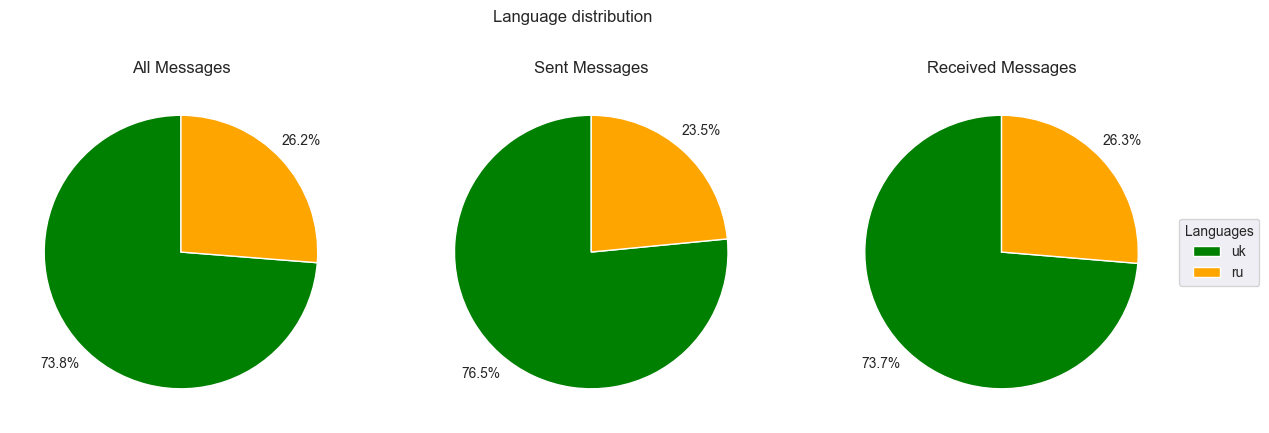

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Language distribution")

get_piechart_of_language(df, ax=ax1, title="All Messages")
get_piechart_of_language(get_df_of_send_messages(df), ax=ax2, title="Sent Messages")
get_piechart_of_language(get_df_of_received_messages(df), ax=ax3, title="Received Messages", add_legend=True)

plt.show()

In [43]:
def messages_per_date(messages):
    return messages.groupby(['date']).size()

In [44]:
def get_plot_of_language_per_time(df, title=None):
    df_lang_uk = df[df['language'] == 'uk']
    df_lang_ru = df[df['language'] == 'ru']
    
    uk_ru = pd.DataFrame()
    uk_ru['uk'] = messages_per_date(df_lang_uk)
    uk_ru['ru'] = messages_per_date(df_lang_ru)
    
    uk_ru.fillna(0, axis=1).plot(figsize=(20, 10), color=['green', 'orange'])
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    plt.title(title)
    
    return plt

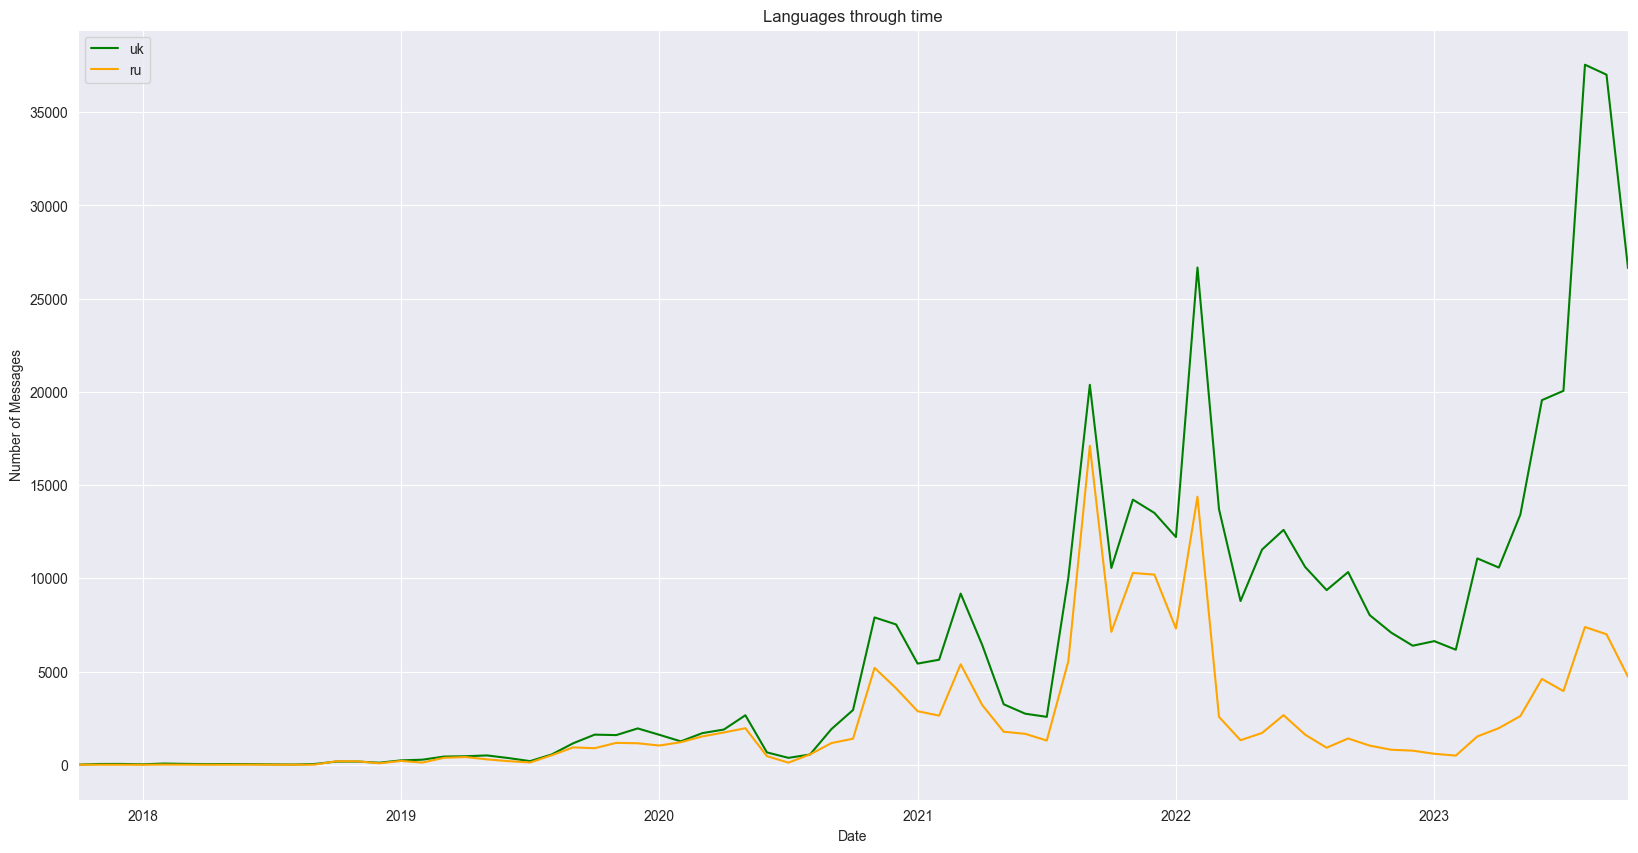

In [32]:
plt = get_plot_of_language_per_time(df, 'Languages through time')
plt.show()

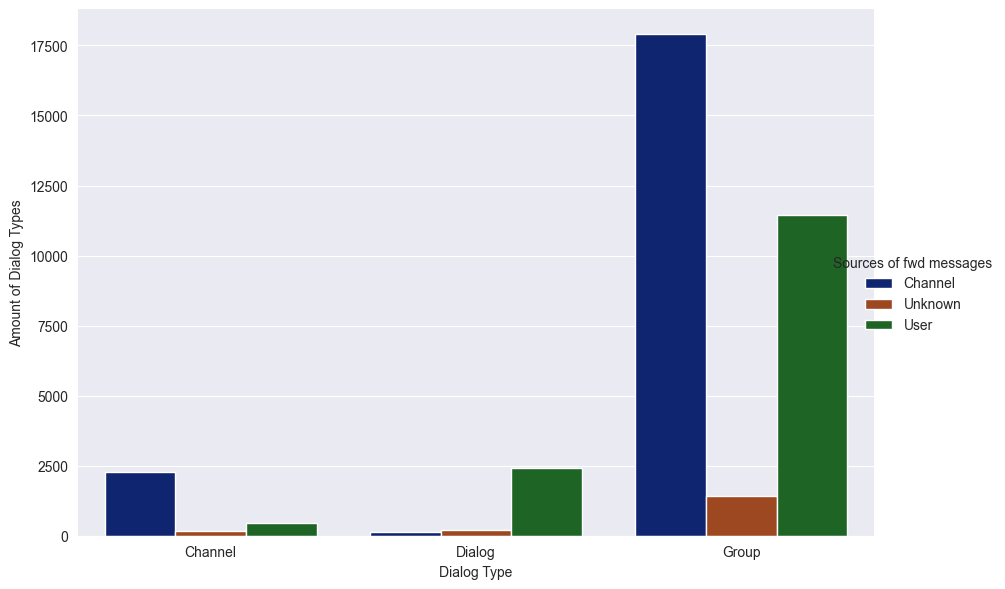

In [73]:
df_grouped = df.groupby(['dialog_type', 'fwd_from_source']).size().reset_index(name='count')

g = sns.catplot(
    data=df_grouped, kind="bar",
    x="dialog_type", y="count", hue="fwd_from_source",
    height=6, aspect=1.5, palette="dark"
)

g.despine(left=True)
g.set_axis_labels("Dialog Type", "Amount of Dialog Types")
g.legend.set_title("Sources of fwd messages")

### Private dialogs analysis

In [83]:
private_send_msg = get_df_of_send_messages(private_dialogs_df)
private_received_msg = get_df_of_received_messages(private_dialogs_df)

In [73]:
def get_emojis_from_messages(df, top=None):
    emojis_from_messages = df['emoji']

    emojis = {}
    for item in emojis_from_messages:
        for e in item:
            if e in emojis:
                emojis[e] += 1
            else:
                emojis[e] = 1

    sorted_emojis = sorted(emojis.items(), key=lambda item: item[1], reverse=True)[:top]
    return dict(sorted_emojis)

In [97]:
def get_top_emojis(dict_emoj, title):
    emojis = list(dict_emoj.keys())
    counts = list(dict_emoj.values())
    df_emojis = pd.DataFrame({'emoji': emojis, 'count': counts})
    
    fig = px.bar(df_emojis, x='emoji', y='count', title=title)
    fig.update_layout(width=700, height=700)
    
    return fig

In [92]:
all_emojis_i_sent = get_emojis_from_messages(get_df_of_send_messages(df), top=10)
fig = get_top_emojis(all_emojis_i_sent, 'My top-10 emojis')
fig.show()

In [48]:
send_top_users = get_dialogs_with_most_messages(private_send_msg)
received_top_users = get_dialogs_with_most_messages(private_received_msg)

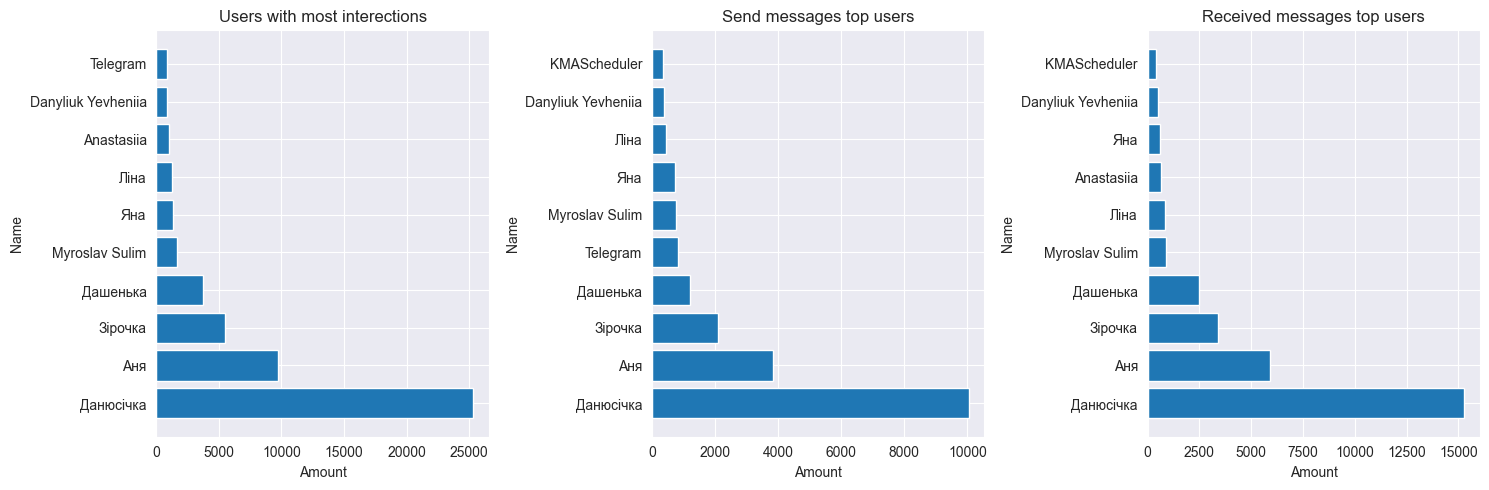

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a row of 2 subplots

# First Plot
axs[0].barh(get_dialogs_with_most_messages(private_dialogs_df)['name'], get_dialogs_with_most_messages(private_dialogs_df)['amount'])
axs[0].set_xlabel('Amount')
axs[0].set_ylabel('Name')
axs[0].set_title("Users with most interections")

# Second Plot
axs[1].barh(send_top_users['name'], send_top_users['amount'])
axs[1].set_xlabel('Amount')
axs[1].set_ylabel('Name')
axs[1].set_title("Send messages top users")

# Third Plot
axs[2].barh(received_top_users['name'], received_top_users['amount'])
axs[2].set_xlabel('Amount')
axs[2].set_ylabel('Name')
axs[2].set_title("Received messages top users")

plt.tight_layout()  # Ensures that the plots do not overlap
plt.show()

In [50]:
def messages_per_time(messages):
    return messages.groupby(['hour']).size()

In [51]:
sent_received = pd.DataFrame()
sent_received['received'] = messages_per_time(private_received_msg)
sent_received['sent'] = messages_per_time(private_send_msg)

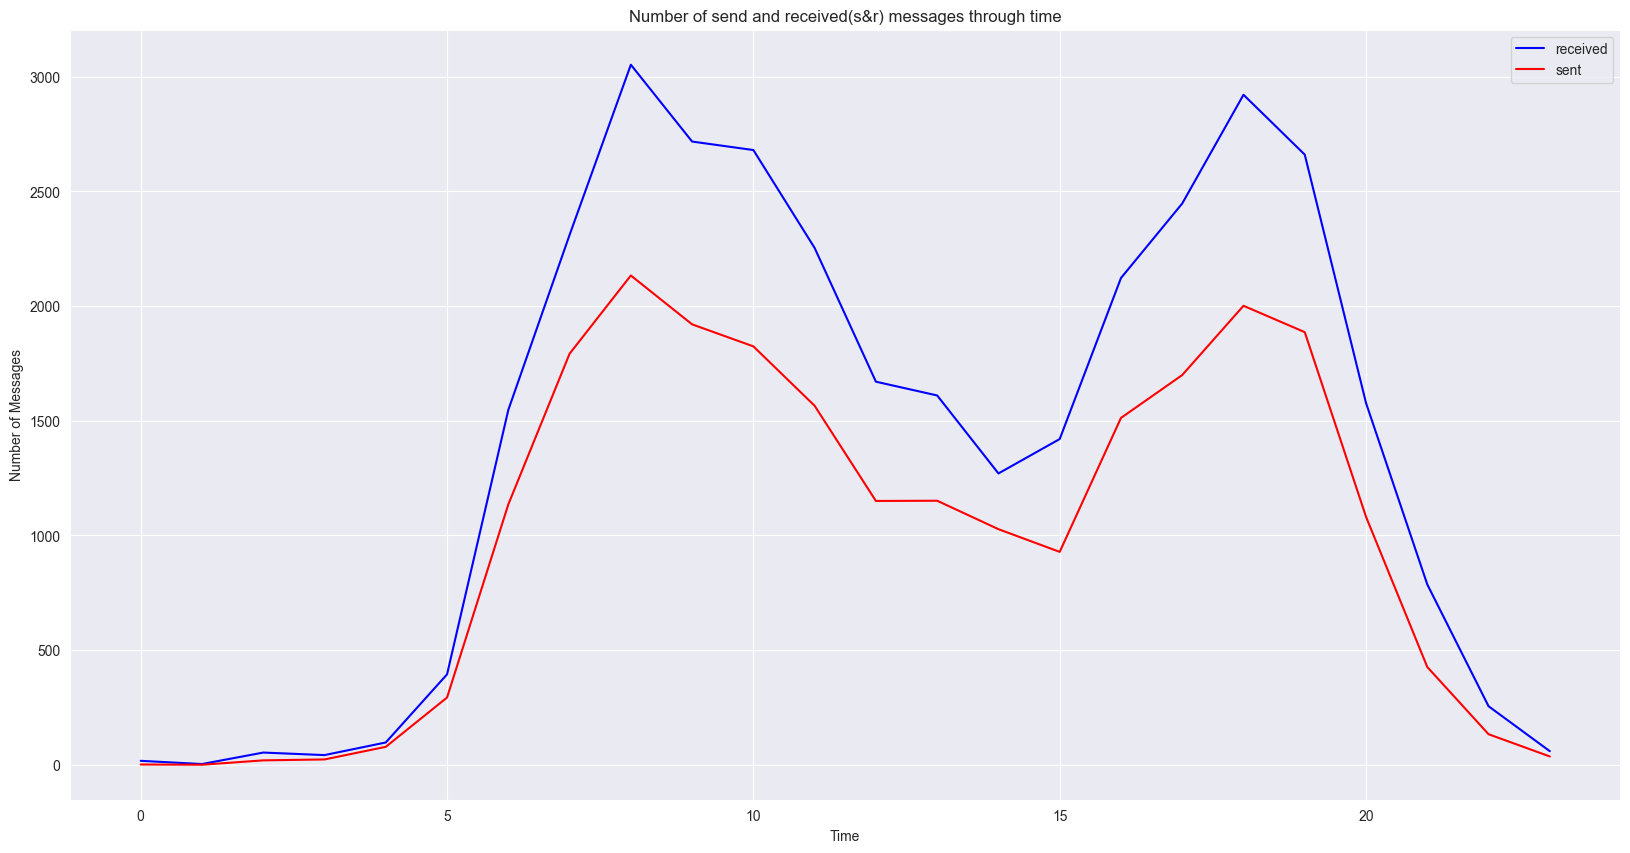

In [52]:
sent_received.fillna(0, axis=1).plot(figsize=(20, 10), color=['blue', 'red'])
plt.xlabel('Time')
plt.ylabel('Number of Messages')
plt.title("Number of send and received(s&r) messages through time")
plt.show()

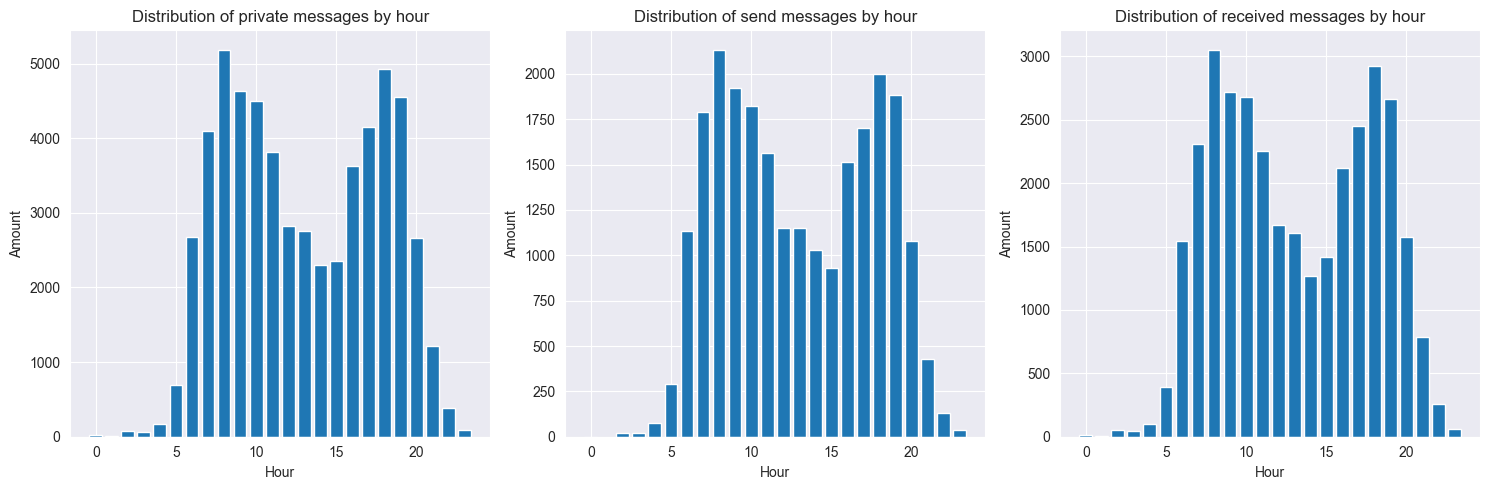

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a row of 3 subplots

# First Plot
counts = private_dialogs_df['hour'].value_counts()
axs[0].bar(counts.index, counts)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Amount')
axs[0].set_title("Distribution of private messages by hour")

# Second Plot
counts = private_send_msg['hour'].value_counts()
axs[1].bar(counts.index, counts)
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Amount')
axs[1].set_title("Distribution of send messages by hour")

# Third Plot
counts = private_received_msg['hour'].value_counts()
axs[2].bar(counts.index, counts)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Amount')
axs[2].set_title("Distribution of received messages by hour")

plt.tight_layout()  # Ensures that the plots do not overlap
plt.show()

In [54]:
def get_most_active_hours(df: pd.DataFrame, limit: int = 5):
    top_people = df.groupby(['hour']).size().sort_values(ascending=False).head(limit)
    data = [[hour, amount] for hour, amount in top_people.items()]

    return pd.DataFrame(data, columns=['hour', 'amount'])

In [55]:
active_hours = get_most_active_hours(private_received_msg)

In [56]:
active_hours

,hour,amount
0,8,3052
1,18,2921
2,9,2717
3,10,2680
4,19,2660


In [31]:
def get_dialog_df(name):
    id = df_meta[df_meta['name'] == name]['dialog_id'].values[0]
    dialog = private_dialogs_df[(private_dialogs_df['dialog_id'] == id)]
    return dialog

In [98]:
from plotly.subplots import make_subplots

def get_top_emojis_subplot(user_name, row, col):
    user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df(user_name)), top=10)
    fig = get_top_emojis(user_emoj, f'Top-10 emojis of {user_name}')
    
    return fig, row, col

# Create subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=['Данюсічка', 'Аня', 'Зірочка', 'Дашенька', 'Myroslav Sulim', 'Яна'])

# Add plots to subplots
fig_1, row_1, col_1 = get_top_emojis_subplot('Данюсічка', 1, 1)
fig_2, row_2, col_2 = get_top_emojis_subplot('Аня', 1, 2)
fig_3, row_3, col_3 = get_top_emojis_subplot('Зірочка', 2, 1)
fig_4, row_4, col_4 = get_top_emojis_subplot('Дашенька', 2, 2)
fig_5, row_5, col_5 = get_top_emojis_subplot('Myroslav Sulim', 3, 1)
fig_6, row_6, col_6 = get_top_emojis_subplot('Яна', 3, 2)

# Update subplots
fig.update_layout(showlegend=False)  # Hide individual legends
fig.add_trace(fig_1.data[0], row=row_1, col=col_1)
fig.add_trace(fig_2.data[0], row=row_2, col=col_2)
fig.add_trace(fig_3.data[0], row=row_3, col=col_3)
fig.add_trace(fig_4.data[0], row=row_4, col=col_4)
fig.add_trace(fig_5.data[0], row=row_5, col=col_5)
fig.add_trace(fig_6.data[0], row=row_6, col=col_6)

# Update layout
fig.update_layout(title_text='Top-10 Emojis in Received Messages')
fig.show()


In [95]:
user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Данюсічка')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Данюсічка')
fig.show()

user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Аня')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Аня')
fig.show()

user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Зірочка')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Зірочка')
fig.show()

user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Дашенька')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Дашенька')
fig.show()

user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Myroslav Sulim')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Myroslav Sulim')
fig.show()

user_emoj = get_emojis_from_messages(get_df_of_received_messages(get_dialog_df('Яна')), top=10)
fig = get_top_emojis(user_emoj, 'Top-10 emojis of Яна')
fig.show()

#### TF-IDF

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
cv = CountVectorizer()

In [107]:
def get_docs(date, user_df):
    df_day_dialog = user_df[user_df['date'] == date]
    conversation = ''
    for i in range(df_day_dialog.shape[0]-1):
        conversation += df_day_dialog['clean_message'].iloc[i]
    return conversation


def get_top_tf_idf(user_df, name, top):
    
    docs_dialog_df = pd.DataFrame({'date': user_df['date'].unique(), 'text': ''})
    docs_dialog_df['text'] = docs_dialog_df['date'].apply(lambda x: get_docs(x, user_df))
    
    docs = docs_dialog_df['text'].tolist()
    
    word_count_vector = cv.fit_transform(docs)
    tfidf_transformer = TfidfTransformer()
    tfidf_transformer.fit(word_count_vector)
    tf_idf_vector = tfidf_transformer.transform(word_count_vector)
    
    feature_names = cv.get_feature_names_out()
    tfidf_df = pd.DataFrame(tf_idf_vector.toarray(), columns=feature_names)
    average_tfidf_scores = tfidf_df.mean()
    
    top_10_words = average_tfidf_scores.nlargest(top)
    
    plt.figure(figsize=(7, 5))
    top_10_words.plot(kind='bar', color='skyblue')
    plt.title(f'Top 10 Words with Highest TF-IDF Scores for {name}')
    plt.xlabel('Words')
    plt.ylabel('Average TF-IDF Score')
    plt.xticks(rotation=45, ha='right')
    
    return plt 

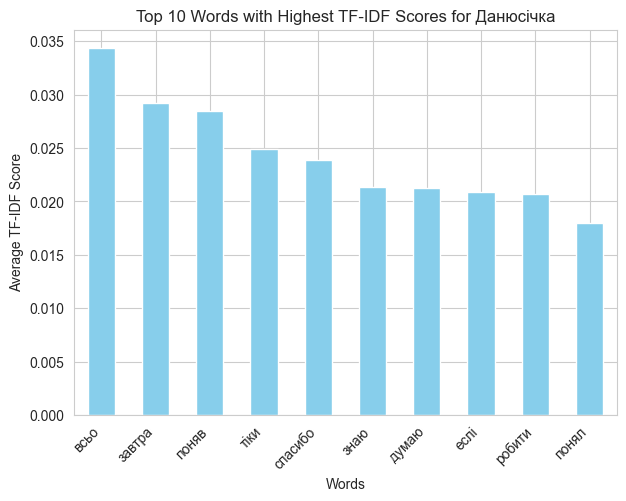

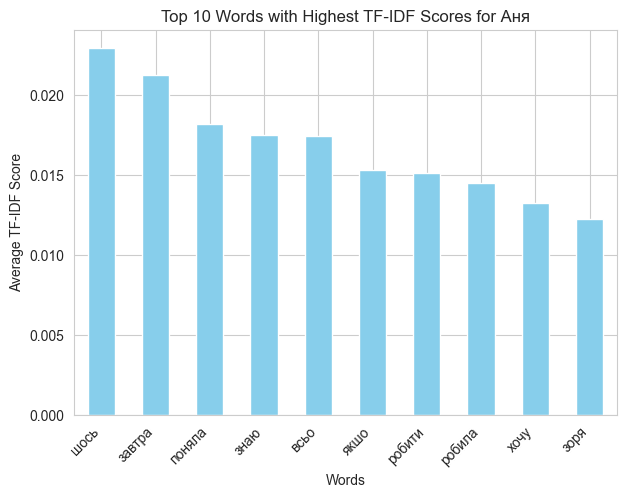

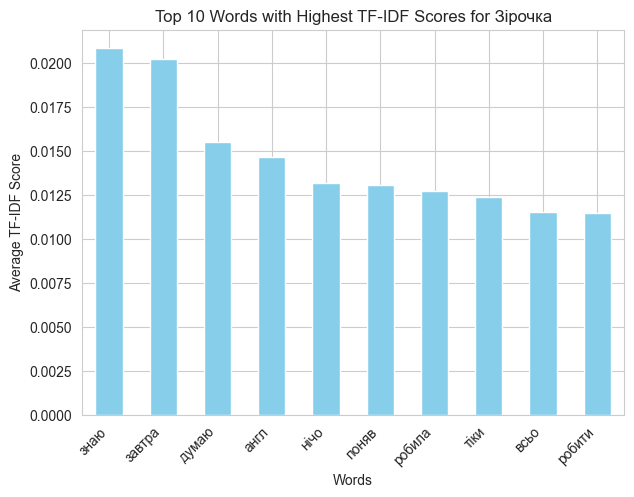

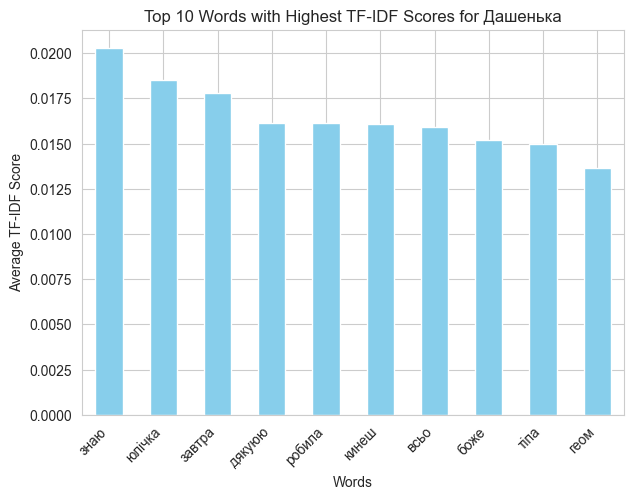

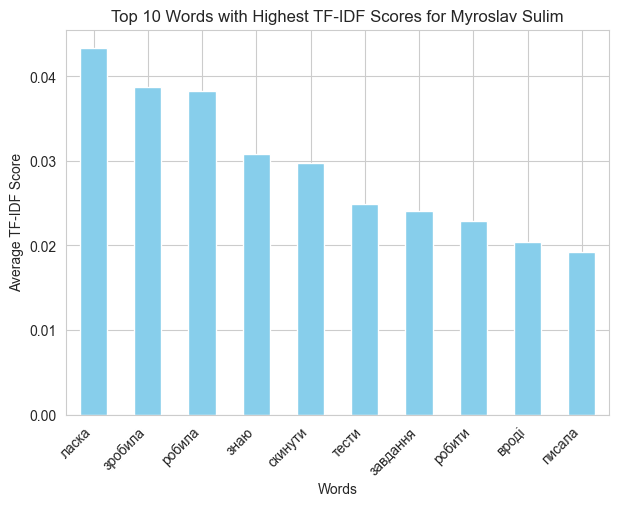

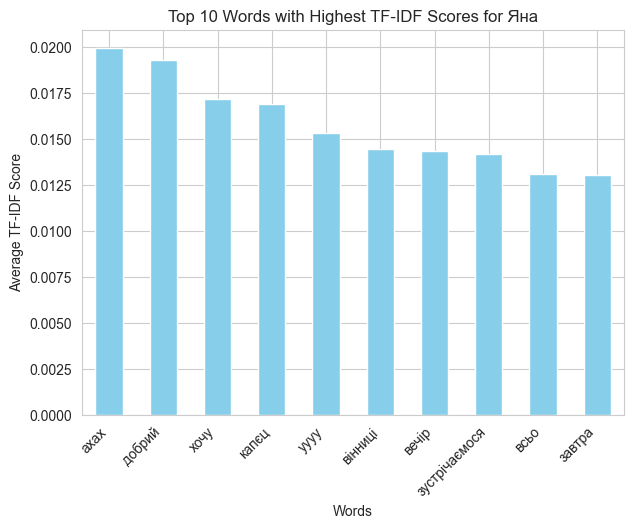

In [108]:
user_df = get_dialog_df('Данюсічка')
plt = get_top_tf_idf(user_df, 'Данюсічка', 10)
plt.show()

user_df = get_dialog_df('Аня')
plt = get_top_tf_idf(user_df, 'Аня', 10)
plt.show()

user_df = get_dialog_df('Зірочка')
plt = get_top_tf_idf(user_df, 'Зірочка', 10)
plt.show()

user_df = get_dialog_df('Дашенька')
plt = get_top_tf_idf(user_df, 'Дашенька',  10)
plt.show()

user_df = get_dialog_df('Myroslav Sulim')
plt = get_top_tf_idf(user_df, 'Myroslav Sulim', 10)
plt.show()

user_df = get_dialog_df('Яна')
plt = get_top_tf_idf(user_df, 'Яна', 10)
plt.show()

In [25]:
def additional_data_cleaning(data):
    my_stopwords = {'всьо', 'тіки', 'еслі', 'шось', 'шо', 'поняв', 'поняла', 'нічо', 'тіпа', 'ласка', 'капєц', 'типу', 'нема', 'норм'}
    words = word_tokenize(data)

    new_text = ""

    for w in words:
        if w not in my_stopwords:
            new_text = new_text + " " + w

    return new_text

In [26]:
df["clean_message_v2"] = df['clean_message'].apply(lambda x: additional_data_cleaning(x))

In [28]:
df['language_v2'] = 'Unknown'
for i in range(df.shape[0]-1):
    try:
        df['language_v2'].iloc[i] = detect(df['clean_message_v2'].iloc[i])
    except:
        df['language_v2'].iloc[i] = 'Unknown'

In [29]:
def get_docs_v2(date, user_df):
    df_day_dialog = user_df[user_df['date'] == date]
    conversation = ''
    for i in range(df_day_dialog.shape[0]-1):
        conversation += df_day_dialog['clean_message_v2'].iloc[i]
    return conversation

def get_top_tf_idf_v2(user_df, name, top):
    
    docs_dialog_df = pd.DataFrame({'date': user_df['date'].unique(), 'text': ''})
    docs_dialog_df['text'] = docs_dialog_df['date'].apply(lambda x: get_docs_v2(x, user_df))
    
    docs = docs_dialog_df['text'].tolist()
    
    word_count_vector = cv.fit_transform(docs)
    tfidf_transformer = TfidfTransformer()
    tfidf_transformer.fit(word_count_vector)
    tf_idf_vector = tfidf_transformer.transform(word_count_vector)
    
    feature_names = cv.get_feature_names_out()
    tfidf_df = pd.DataFrame(tf_idf_vector.toarray(), columns=feature_names)
    average_tfidf_scores = tfidf_df.mean()
    
    top_10_words = average_tfidf_scores.nlargest(top)
    
    plt.figure(figsize=(10, 6))
    top_10_words.plot(kind='bar', color='skyblue')
    plt.title(f'Top 10 Words with Highest TF-IDF Scores for {name}')
    plt.xlabel('Words')
    plt.ylabel('Average TF-IDF Score')
    plt.xticks(rotation=45, ha='right')
    
    return plt 

In [ ]:
df

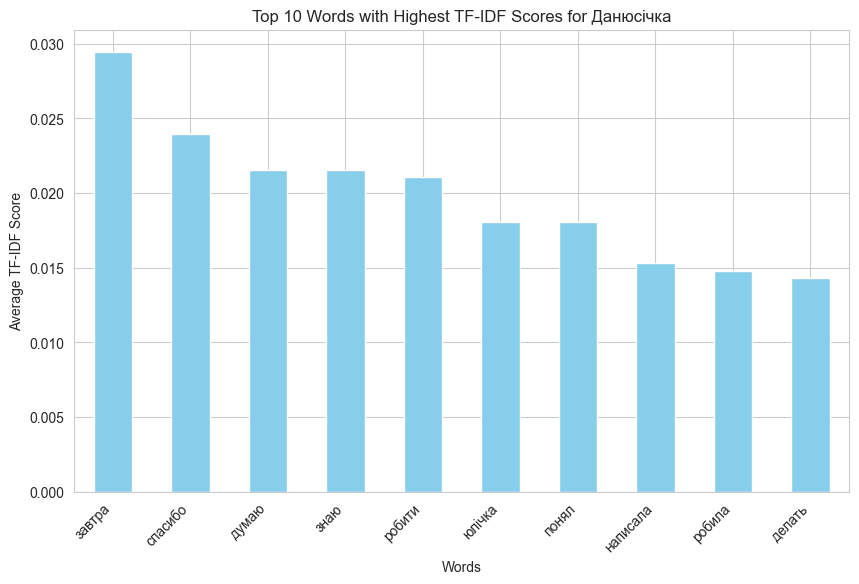

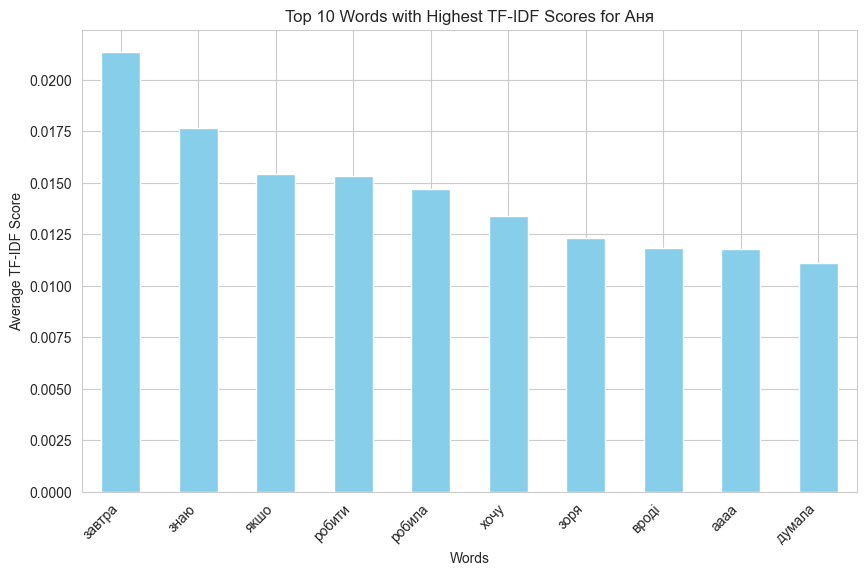

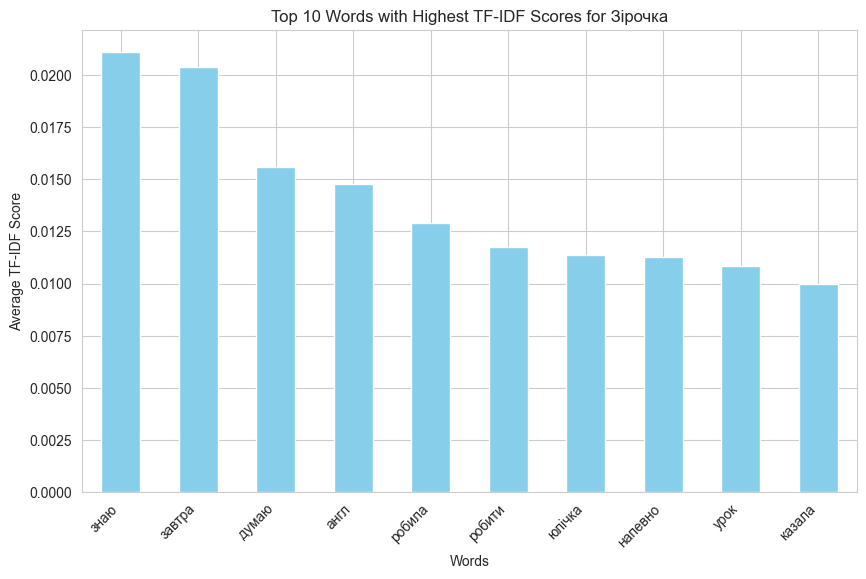

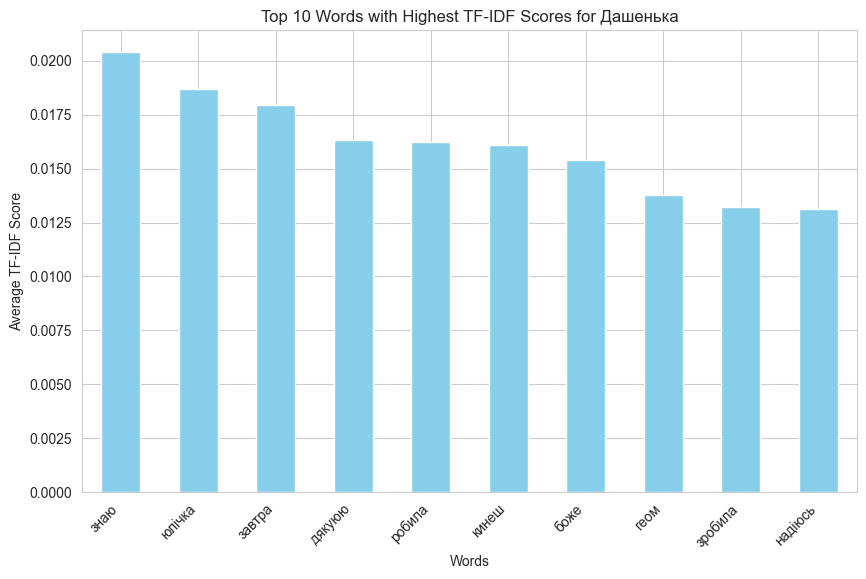

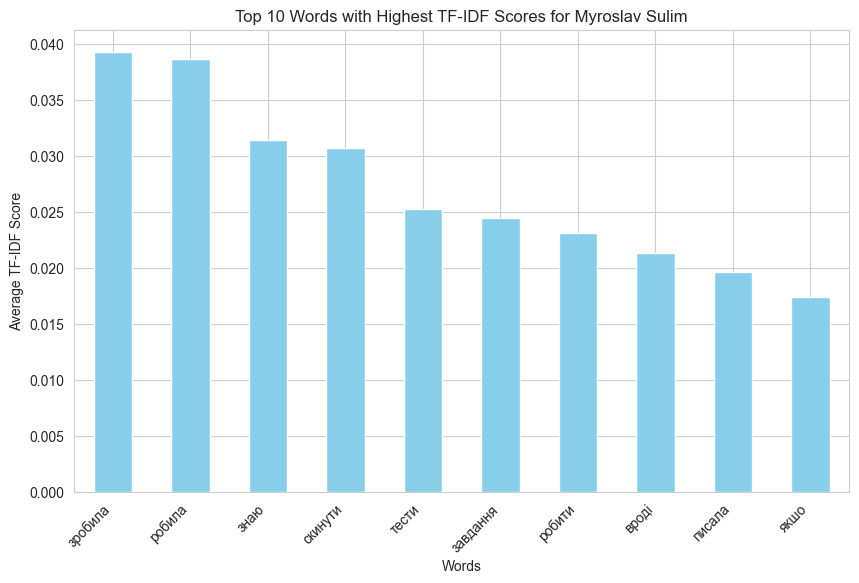

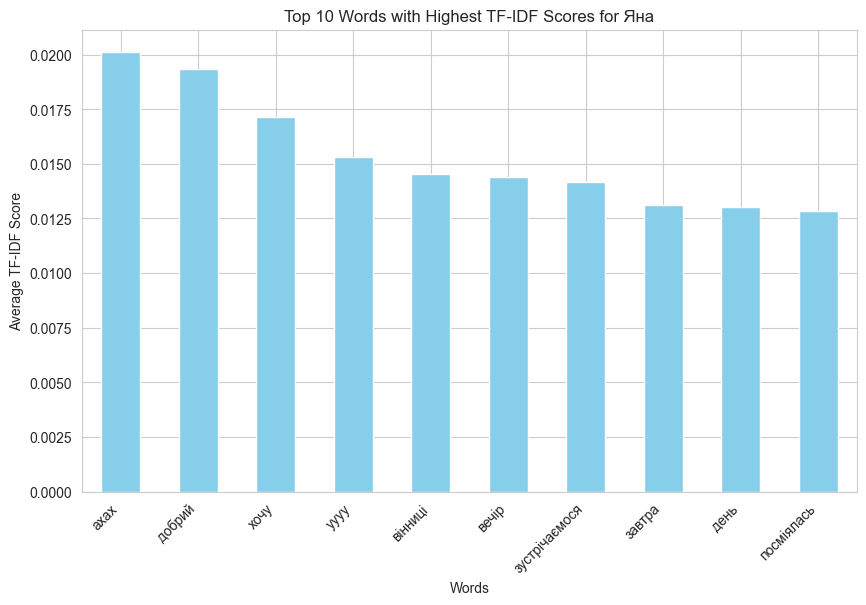

In [37]:
user_df = get_dialog_df('Данюсічка')
plt = get_top_tf_idf_v2(user_df, 'Данюсічка', 10)
plt.show()

user_df = get_dialog_df('Аня')
plt = get_top_tf_idf_v2(user_df, 'Аня', 10)
plt.show()

user_df = get_dialog_df('Зірочка')
plt = get_top_tf_idf_v2(user_df, 'Зірочка', 10)
plt.show()

user_df = get_dialog_df('Дашенька')
plt = get_top_tf_idf_v2(user_df, 'Дашенька',  10)
plt.show()

user_df = get_dialog_df('Myroslav Sulim')
plt = get_top_tf_idf_v2(user_df, 'Myroslav Sulim', 10)
plt.show()

user_df = get_dialog_df('Яна')
plt = get_top_tf_idf_v2(user_df, 'Яна', 10)
plt.show()

In [38]:
def get_piechart_of_language_v2(df, ax=None, title=None, add_legend=False):
    df_lang = df[(df['language_v2'] == 'uk') | (df['language_v2'] == 'ru')]
    counts = df_lang['language_v2'].value_counts()
    wedges, texts, autotexts = ax.pie(counts, labels=None, startangle=90, autopct='%1.1f%%', pctdistance=1.2, colors=['green', 'orange'])
    
    if title:
        ax.set_title(title)
    
    if add_legend:
        ax.legend(wedges, counts.index, title="Languages", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    return ax

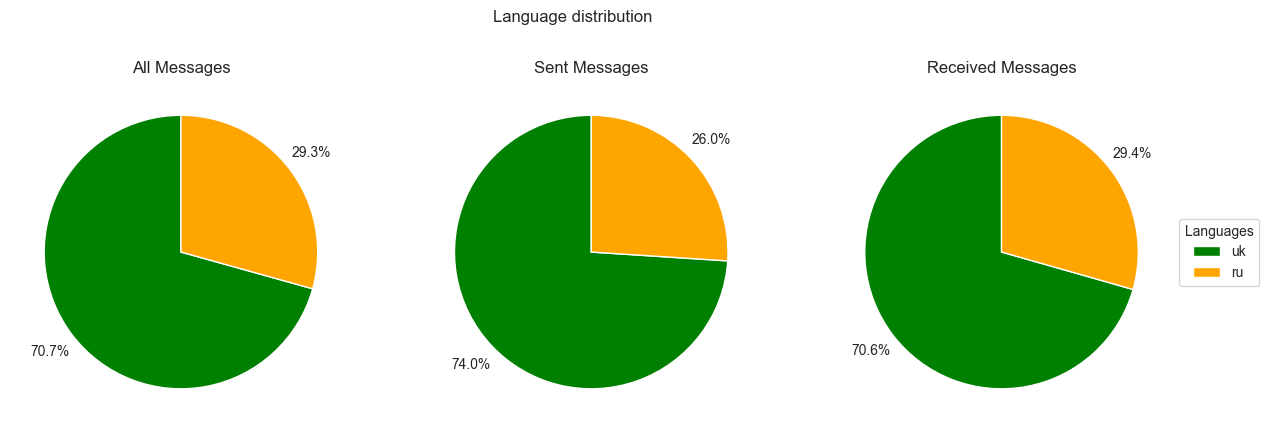

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Language distribution")

get_piechart_of_language_v2(df, ax=ax1, title="All Messages")
get_piechart_of_language_v2(get_df_of_send_messages(df), ax=ax2, title="Sent Messages")
get_piechart_of_language_v2(get_df_of_received_messages(df), ax=ax3, title="Received Messages", add_legend=True)

plt.show()

In [77]:
for i in range(df.shape[0]-1):
    if df['language_v2'].iloc[i] == 'uk':
        df['language'].iloc[i] = df['language_v2'].iloc[i]
        

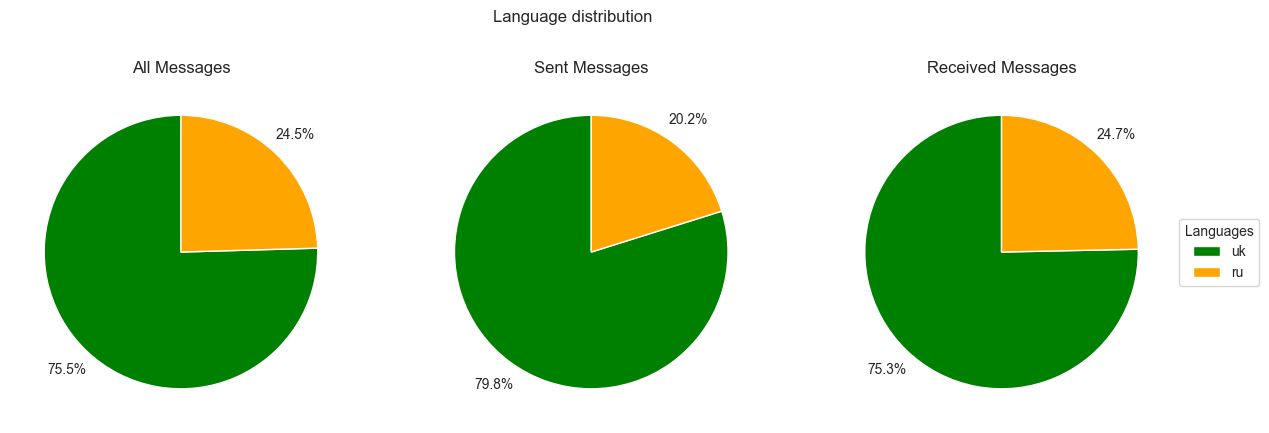

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Language distribution")

get_piechart_of_language(df, ax=ax1, title="All Messages")
get_piechart_of_language(get_df_of_send_messages(df), ax=ax2, title="Sent Messages")
get_piechart_of_language(get_df_of_received_messages(df), ax=ax3, title="Received Messages", add_legend=True)

plt.show()

In [84]:
my_send = get_df_of_send_messages(df)
my_send[my_send['language'] == 'ru']

,id,dialog_id,dialog_type,timestamp,date,year_month,time,hour,from_id,to_id,...,fwd_from_source,message,clean_message,language,emoji,type,duration,reactions,clean_message_v2,language_v2
205236,30205,-1001155360979,Group,2021-03-01 08:01:55,2021-03-01,2021-03,08:01:55,8,770605699,PeerChannel(channel_id=1155360979),...,NaN,Читай ше раз,читай,ru,[],text,NaN,{},читай,bg
206003,29399,-1001155360979,Group,2021-01-25 13:17:04,2021-01-25,2021-01,13:17:04,13,770605699,PeerChannel(channel_id=1155360979),...,NaN,Я беру CO i SiO2,беру sio,ru,[],text,NaN,{},беру sio,mk
207043,28282,-1001155360979,Group,2020-12-22 09:39:19,2020-12-22,2020-12,09:39:19,9,770605699,PeerChannel(channel_id=1155360979),...,NaN,Дякую дуже💖,,ru,[💖],text,NaN,{},,Unknown
208354,26863,-1001155360979,Group,2020-11-30 09:51:26,2020-11-30,2020-11,09:51:26,9,770605699,PeerChannel(channel_id=1155360979),...,User,Iнна Штельмах приглашает вас на запланированну...,iнна штельмах приглашает запланированную конф...,ru,[],text,NaN,{},iнна штельмах приглашает запланированную конф...,ru
209372,25804,-1001155360979,Group,2020-11-12 10:36:16,2020-11-12,2020-11,10:36:16,10,770605699,PeerChannel(channel_id=1155360979),...,NaN,Неееее,неееее,ru,[],text,NaN,{},неееее,ru
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880617,71057,938096171,Dialog,2021-04-05 07:05:06,2021-04-05,2021-04,07:05:06,7,770605699,938096171,...,NaN,В дз 94 неправильно,неправильно,ru,[],text,NaN,{},неправильно,ru
880630,62588,938096171,Dialog,2021-03-05 09:54:05,2021-03-05,2021-03,09:54:05,9,770605699,938096171,...,NaN,Помилок у тестах з алгебри немає,помилок тестах алгебри,ru,[],text,NaN,{},помилок тестах алгебри,ru
880664,51379,938096171,Dialog,2021-01-20 08:23:45,2021-01-20,2021-01,08:23:45,8,770605699,938096171,...,NaN,Вибачте в мене щось комп'ютер не грузить,вибачте компютер грузить,ru,[],photo,NaN,{},вибачте компютер грузить,ru
880712,29654,938096171,Dialog,2020-11-04 10:07:22,2020-11-04,2020-11,10:07:22,10,770605699,938096171,...,NaN,"Вибачте, я не встигла 4.5 зробити. Я постараюс...",вибачте встигла зробити постараюсь зробити,ru,[],photo,NaN,{},вибачте встигла зробити постараюсь зробити,ru


### Groups dialogs analysis

In [46]:
groups_send_msg = get_df_of_send_messages(groups_df)
groups_received_msg = get_df_of_received_messages(groups_df)

In [47]:
send_top_groups = get_dialogs_with_most_messages(groups_send_msg)
received_top_groups = get_dialogs_with_most_messages(groups_received_msg)

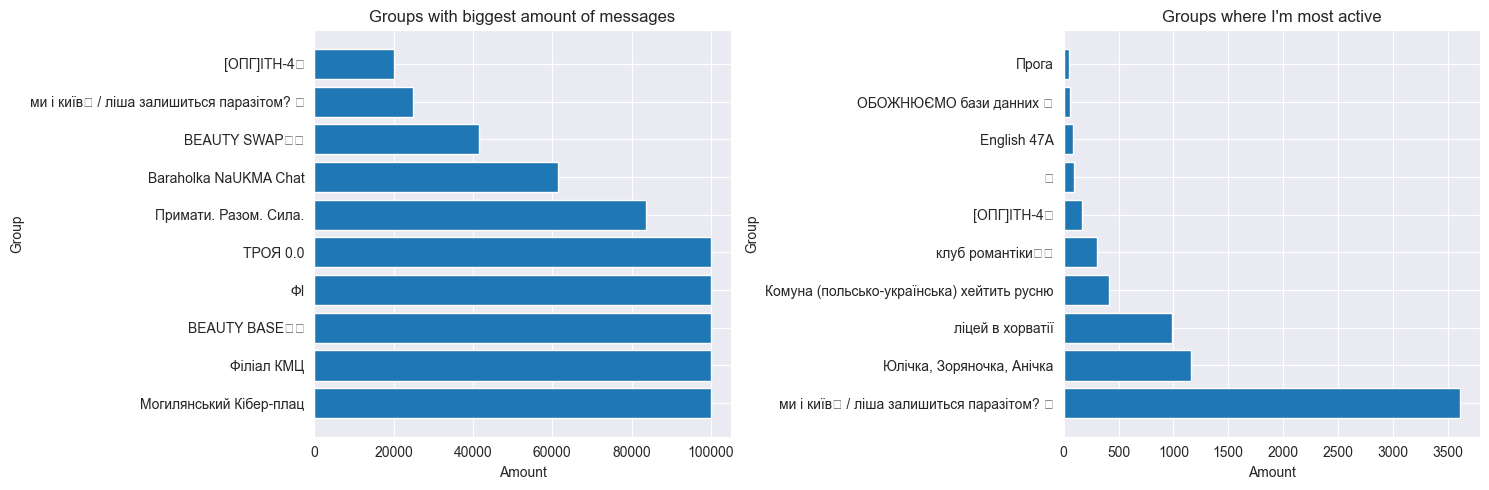

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Create a row of 2 subplots

# First Plot
axs[0].barh(get_dialogs_with_most_messages(groups_df)['name'], get_dialogs_with_most_messages(groups_df)['amount'])
axs[0].set_xlabel('Amount')
axs[0].set_ylabel('Group')
axs[0].set_title("Groups with biggest amount of messages")

# Second Plot
axs[1].barh(send_top_groups['name'], send_top_groups['amount'])
axs[1].set_xlabel('Amount')
axs[1].set_ylabel('Group')
axs[1].set_title("Groups where I'm most active")

plt.tight_layout()  # Ensures that the plots do not overlap
plt.show()

In [60]:
sent_received_groups = pd.DataFrame()
sent_received_groups['received'] = messages_per_time(get_df_of_received_messages(groups_df))
sent_received_groups['sent'] = messages_per_time(get_df_of_send_messages(groups_df))

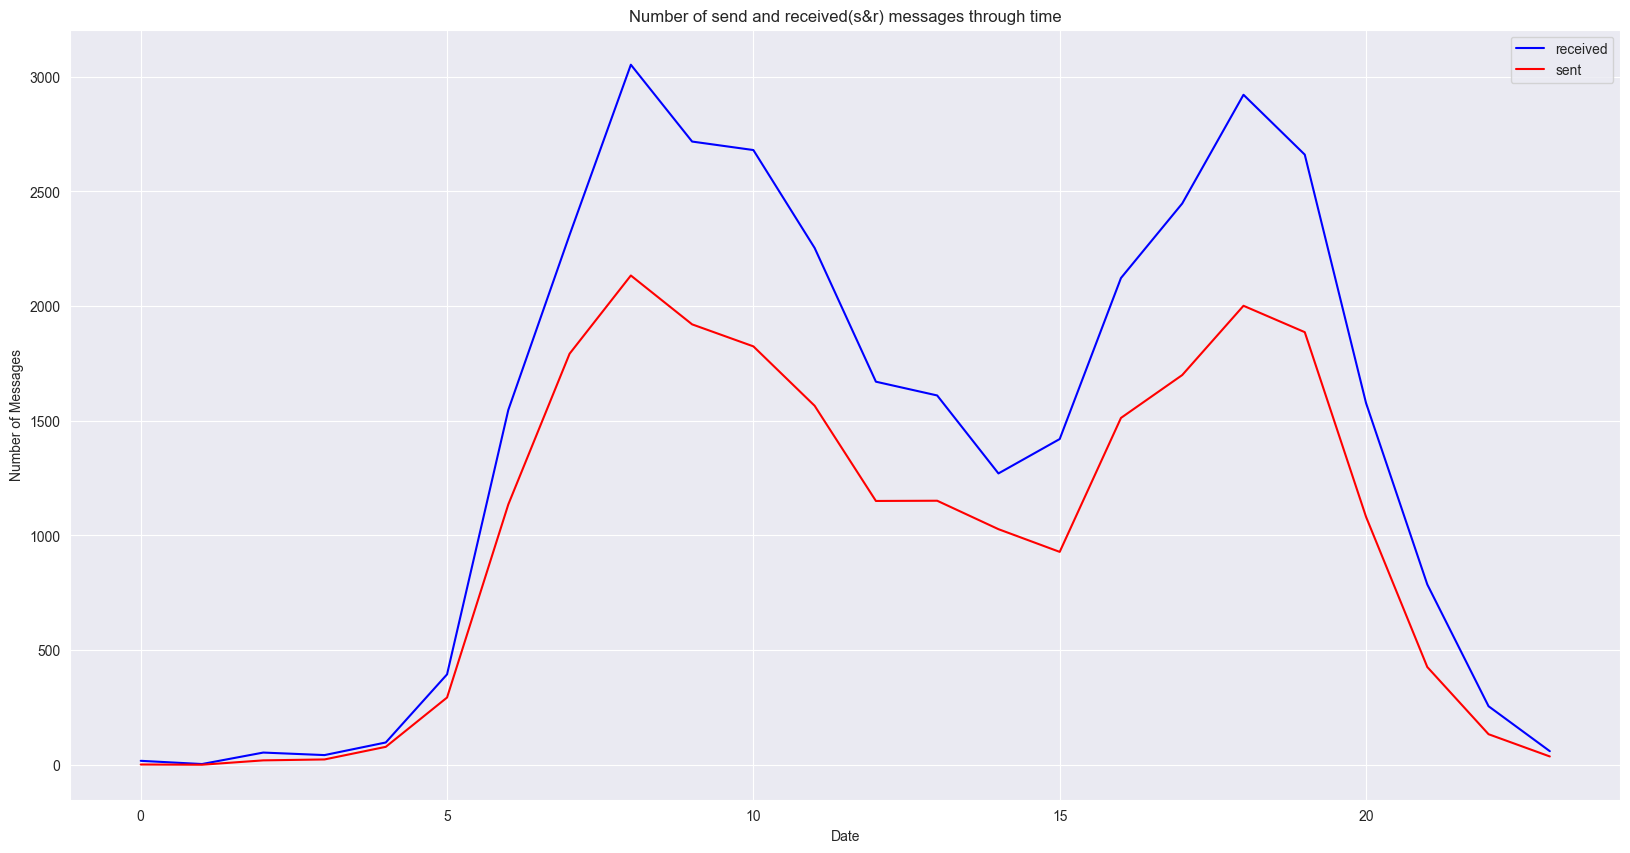

In [61]:
sent_received.fillna(0, axis=1).plot(figsize=(20, 10), color=['blue', 'red'])
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.title("Number of send and received(s&r) messages through time")
plt.show()

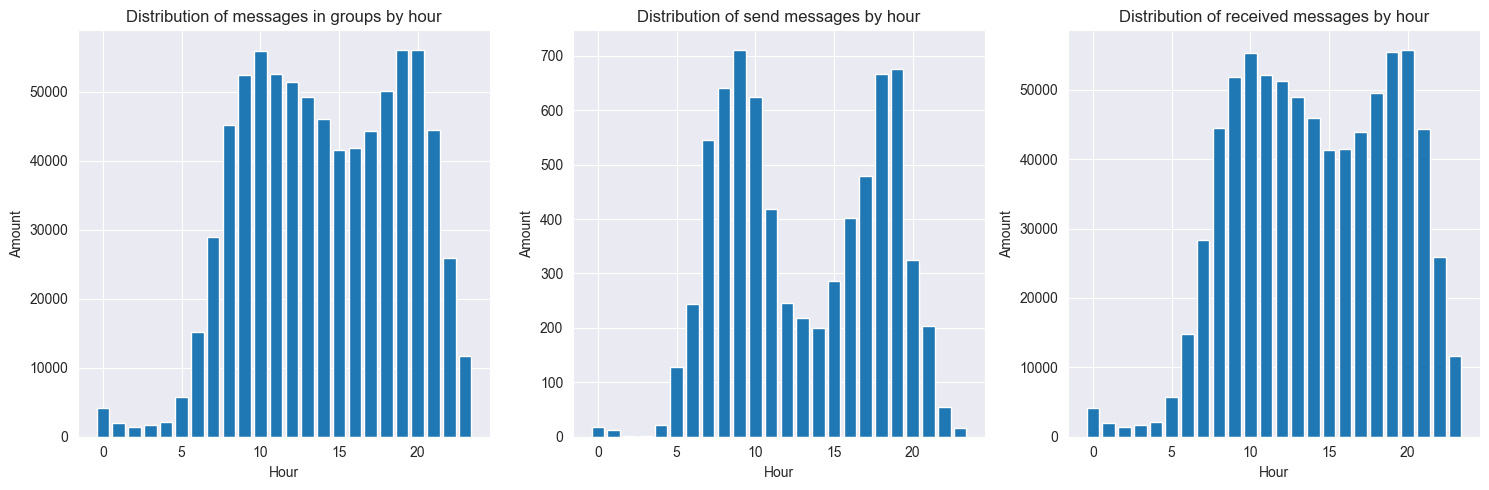

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Create a row of 3 subplots

# First Plot
counts = groups_df['hour'].value_counts()
axs[0].bar(counts.index, counts)
axs[0].set_xlabel('Hour')
axs[0].set_ylabel('Amount')
axs[0].set_title("Distribution of messages in groups by hour")

# Second Plot
counts = get_df_of_send_messages(groups_df)['hour'].value_counts()
axs[1].bar(counts.index, counts)
axs[1].set_xlabel('Hour')
axs[1].set_ylabel('Amount')
axs[1].set_title("Distribution of send messages by hour")

# Third Plot
counts = get_df_of_received_messages(groups_df)['hour'].value_counts()
axs[2].bar(counts.index, counts)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Amount')
axs[2].set_title("Distribution of received messages by hour")

plt.tight_layout()  # Ensures that the plots do not overlap
plt.show()

#### Analysis of Могилянський Кібер-плац

In [49]:
cyberplats_df = groups_df[groups_df['dialog_id'] == -1001695031361]

In [59]:
cyberplats_df

,id,dialog_id,dialog_type,timestamp,date,year_month,time,hour,from_id,to_id,...,fwd_from_source,message,clean_message,language,emoji,type,duration,reactions,clean_message_v2,language_v2
670563,685092,-1001695031361,Group,2023-10-22 21:35:44,2023-10-22,2023-10,21:35:44,21,229463373,PeerChannel(channel_id=1695031361),...,NaN,Поняв.,поняв,bg,[],text,NaN,{1690741228: <telethon.tl.types.ReactionEmoji ...,,Unknown
670564,685091,-1001695031361,Group,2023-10-22 21:35:26,2023-10-22,2023-10,21:35:26,21,1690741228,PeerChannel(channel_id=1695031361),...,NaN,Протягом минулого року Данило регулярно постив...,минулого данило регулярно постив картинку чат...,uk,[],text,NaN,{935940601: <telethon.tl.types.ReactionEmoji o...,минулого данило регулярно постив картинку чат...,uk
670565,685090,-1001695031361,Group,2023-10-22 21:33:11,2023-10-22,2023-10,21:33:11,21,229463373,PeerChannel(channel_id=1695031361),...,NaN,?)))\n\nЦе з гри Call of Duty: Modern Warfare ...,call duty modern warfare remastered,en,[],text,NaN,{453357274: <telethon.tl.types.ReactionEmoji o...,call duty modern warfare remastered,en
670566,685089,-1001695031361,Group,2023-10-22 21:31:49,2023-10-22,2023-10,21:31:49,21,399310806,PeerChannel(channel_id=1695031361),...,NaN,підтримую,підтримую,uk,[],text,NaN,{},підтримую,uk
670567,685088,-1001695031361,Group,2023-10-22 21:31:34,2023-10-22,2023-10,21:31:34,21,412832908,PeerChannel(channel_id=1695031361),...,NaN,"окрім волейболу, волейбол весело дивитися)",волейболу волейбол весело дивитися,ru,[],text,NaN,{1690741228: <telethon.tl.types.ReactionEmoji ...,волейболу волейбол весело дивитися,ru
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770558,581593,-1001695031361,Group,2023-06-12 08:54:55,2023-06-12,2023-06,08:54:55,8,412832908,PeerChannel(channel_id=1695031361),...,NaN,"ну чого ти, це ж не псж)",,uk,[],text,NaN,{},,Unknown
770559,581592,-1001695031361,Group,2023-06-12 08:54:44,2023-06-12,2023-06,08:54:44,8,230295237,PeerChannel(channel_id=1695031361),...,NaN,це як,,uk,[],text,NaN,{},,Unknown
770560,581591,-1001695031361,Group,2023-06-12 08:54:34,2023-06-12,2023-06,08:54:34,8,230295237,PeerChannel(channel_id=1695031361),...,Channel,❗️Виробник Patriot пообіцяв передачу Україні д...,виробник patriot пообіцяв передачу україні до...,uk,[❗],text,NaN,{409784082: <telethon.tl.types.ReactionEmoji o...,виробник patriot пообіцяв передачу україні до...,uk
770561,581590,-1001695031361,Group,2023-06-12 08:54:33,2023-06-12,2023-06,08:54:33,8,367903709,PeerChannel(channel_id=1695031361),...,NaN,"Прибери гівно з чату, пліз)",прибери гівно чату пліз,uk,[],text,NaN,{412832908: <telethon.tl.types.ReactionEmoji o...,прибери гівно чату пліз,uk


In [51]:
df_meta['users'] = df_meta['users'].apply(ast.literal_eval)

In [52]:
df_meta['user_id'] = df_meta['users'].apply(lambda x: x.get('user_id'))
df_meta['first_name'] = df_meta['users'].apply(lambda x: x.get('first_name'))
df_meta['last_name'] = df_meta['users'].apply(lambda x: x.get('last_name'))
df_meta['username'] = df_meta['users'].apply(lambda x: x.get('username'))
df_meta['phone'] = df_meta['users'].apply(lambda x: x.get('phone'))
df_meta = df_meta.drop('users', axis=1)

Merged cyberplats messages with information about user that send message

In [60]:
df_meta['user_id'] = df_meta['user_id'].astype(int)
cyberplats_df['from_id'] = cyberplats_df['from_id'].astype('int64')
cyberplats_df_v2 = pd.merge(cyberplats_df, df_meta[['user_id', 'first_name', 'last_name', 'username', 'phone']], 
                            left_on='from_id', right_on='user_id', how='left')

cyberplats_df_v2.drop('user_id', axis=1, inplace=True)

In [57]:
def get_users_with_most_messages(df: pd.DataFrame, limit: int = 10):
    top_people = df.groupby(['from_id']).size().sort_values(ascending=False).head(limit)
    data = [[df[df['from_id'] == id].username.iloc[0], amount] for id, amount in top_people.items()]

    return pd.DataFrame(data, columns=['name', 'amount'])

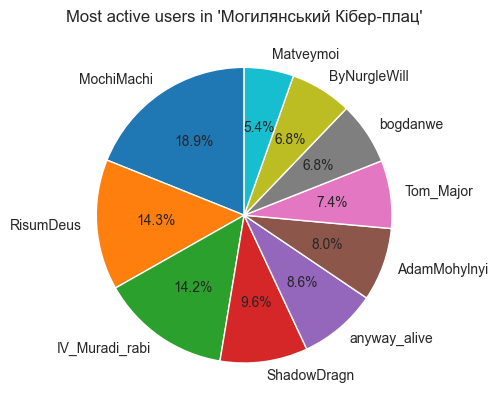

In [193]:
plt.pie(get_users_with_most_messages(cyberplats_df_v2)['amount'], labels = get_users_with_most_messages(cyberplats_df_v2)['name'], 
        startangle = 90, autopct='%1.1f%%')
plt.title("Most active users in 'Могилянський Кібер-плац'")
plt.show()

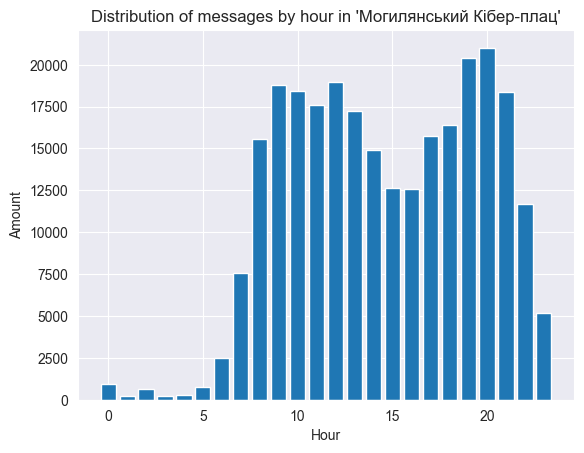

In [70]:
counts = cyberplats_df_v2['hour'].value_counts()
plt.bar(counts.index, counts)
plt.xlabel('Hour')
plt.ylabel('Amount')
plt.title("Distribution of messages by hour in 'Могилянський Кібер-плац'")
plt.show()

In [72]:
def get_day_night_column(df: pd.DataFrame):
    df['day_night'] = np.select(
        [df['hour'].isin(range(9, 21))],
        ['Day'],
        default='Night'
    )
    return df

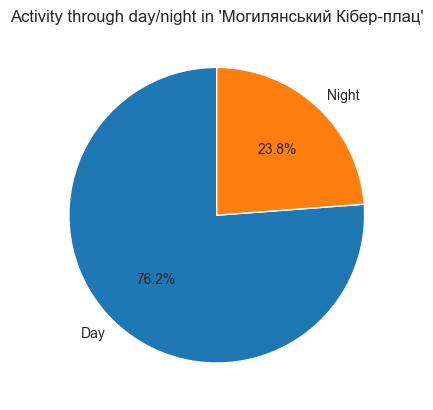

In [74]:
cyberplats_df_v2 = get_day_night_column(cyberplats_df_v2)

counts = cyberplats_df_v2['day_night'].value_counts()
plt.pie(counts, labels = counts.index, 
        startangle = 90, autopct='%1.1f%%')
plt.title("Activity through day/night in 'Могилянський Кібер-плац'")
plt.show()

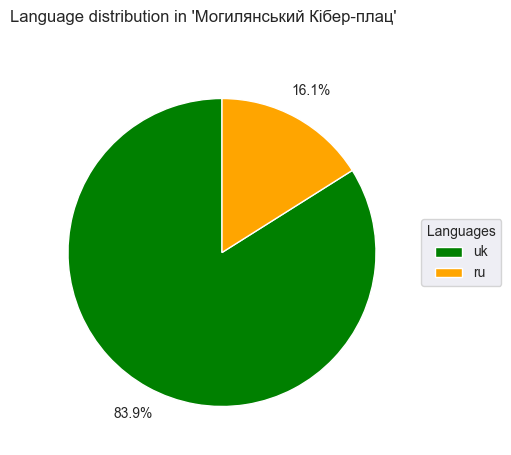

In [75]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle("Language distribution in 'Могилянський Кібер-плац'")

get_piechart_of_language(cyberplats_df, ax=ax1, add_legend=True)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

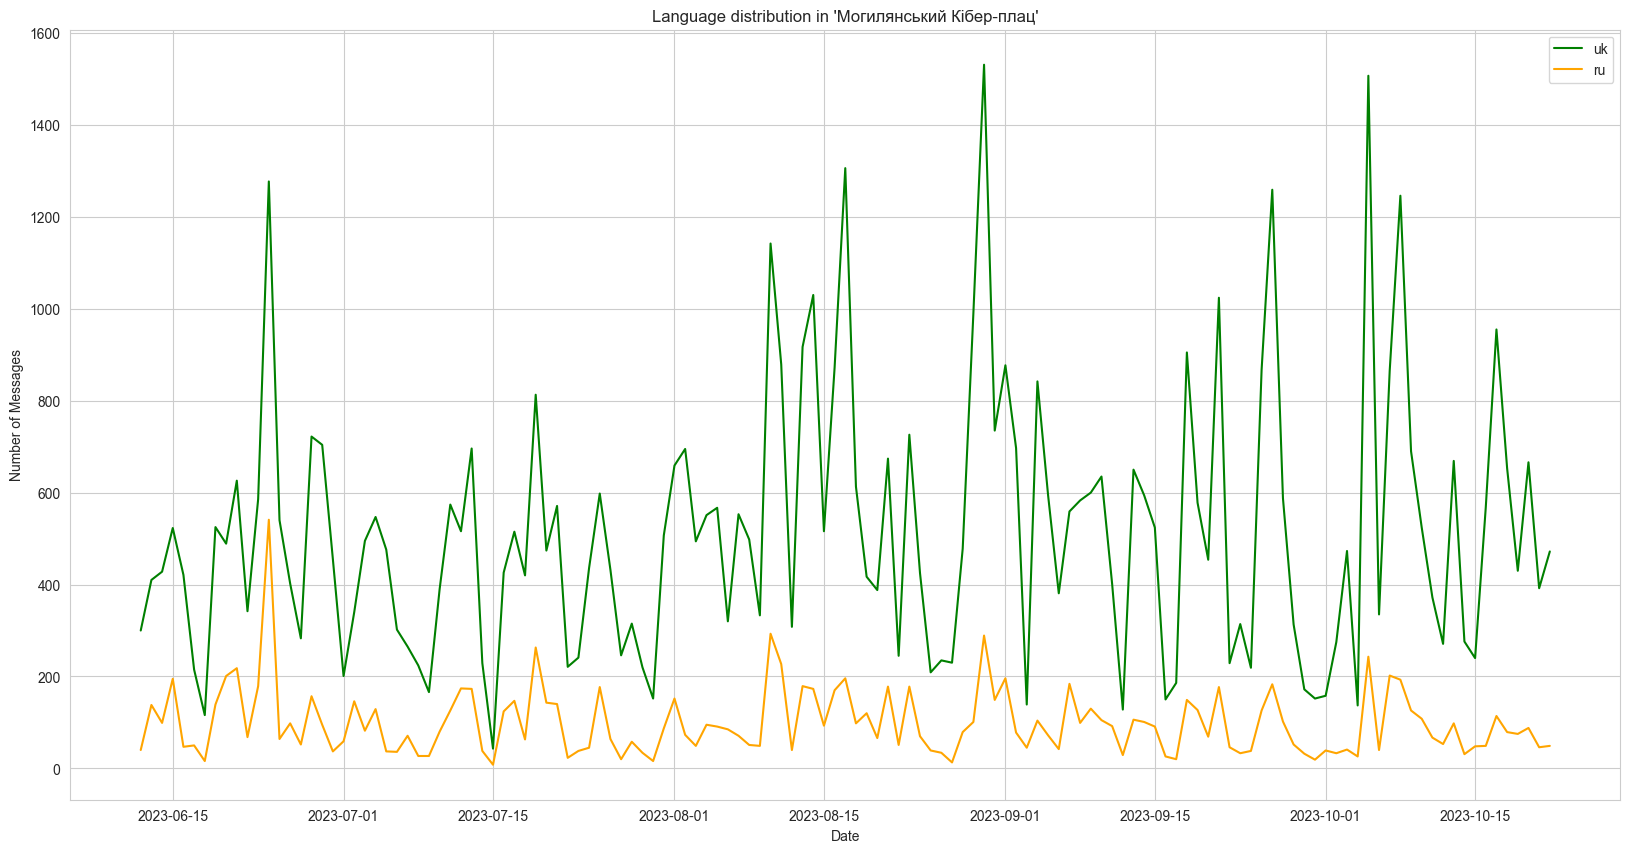

In [54]:
get_plot_of_language_per_time(cyberplats_df, "Language distribution in 'Могилянський Кібер-плац'").show

In [97]:
cyberpl_time = pd.DataFrame()
cyberpl_time['count'] = cyberplats_df.groupby(['date']).size()
fig = px.line(cyberpl_time, x=cyberpl_time.index, y='count', title="Time Series of messages in 'Могилянський Кібер-плац'")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

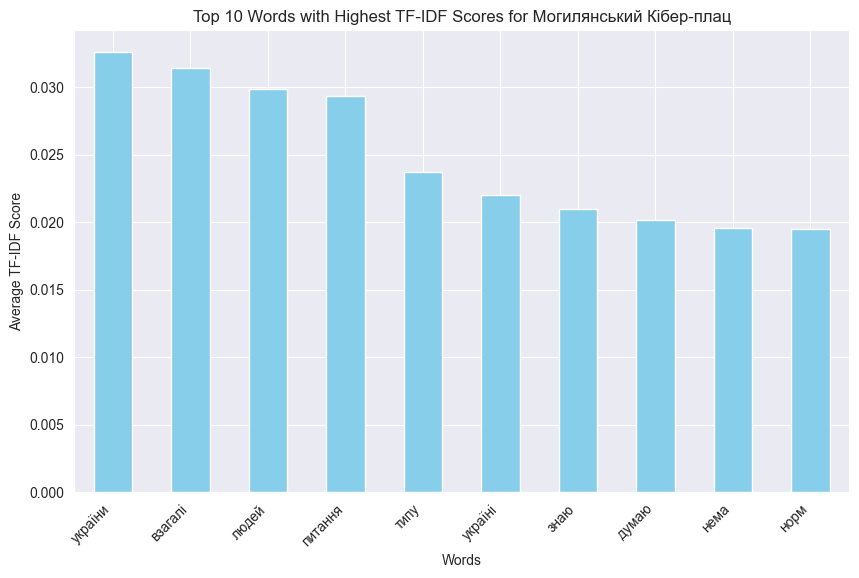

In [194]:
plt = get_top_tf_idf(cyberplats_df, 'Могилянський Кібер-плац', 10)
plt.show()

In [208]:
channel_emoj = get_emojis_from_messages(cyberplats_df, top=10)
fig = get_top_emojis(channel_emoj, "Top-10 emojis of 'Могилянський Кібер-плац'")
fig.show()

#### Analysis of BEAUTY BASE🧴📝

In [70]:
beauty_base_df = groups_df[groups_df['dialog_id'] == -1001359202719]

In [71]:
beauty_base_df['from_id'] = beauty_base_df['from_id'].astype('int64')
beauty_base_df_v2 = pd.merge(beauty_base_df, df_meta[['user_id', 'first_name', 'last_name', 'username', 'phone']], 
                            left_on='from_id', right_on='user_id', how='left')

beauty_base_df_v2.drop('user_id', axis=1, inplace=True)

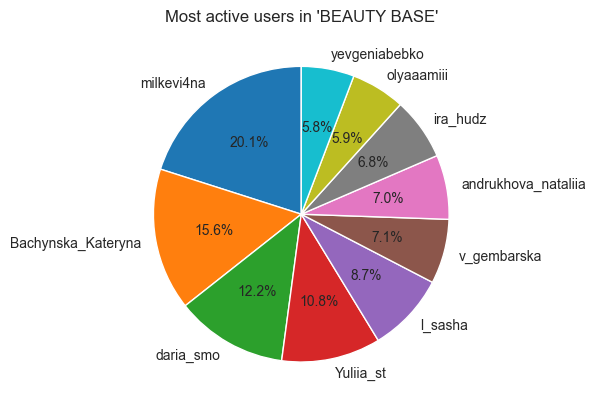

In [197]:
plt.pie(get_users_with_most_messages(beauty_base_df_v2)['amount'], labels = get_users_with_most_messages(beauty_base_df_v2)['name'], 
        startangle = 90, autopct='%1.1f%%')
plt.title("Most active users in 'BEAUTY BASE'")
plt.show()

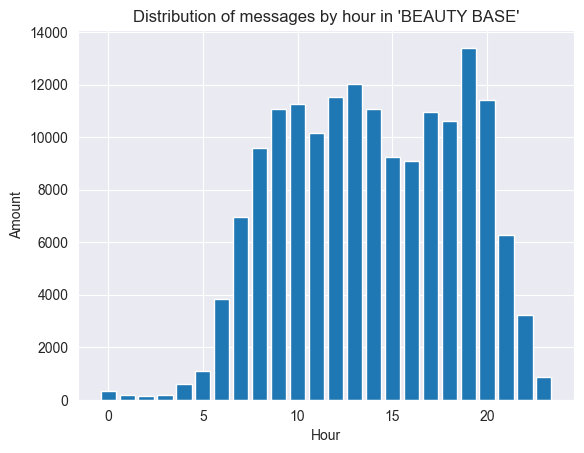

In [198]:
counts = beauty_base_df_v2['hour'].value_counts()
plt.bar(counts.index, counts)
plt.xlabel('Hour')
plt.ylabel('Amount')
plt.title("Distribution of messages by hour in 'BEAUTY BASE'")
plt.show()

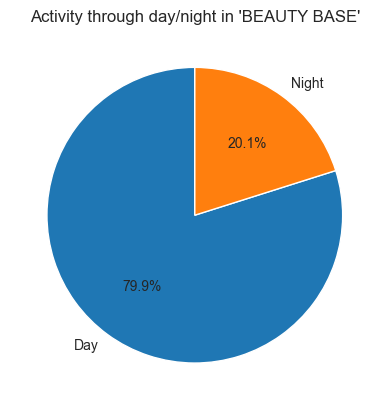

In [81]:
beauty_base_df_v2 = get_day_night_column(beauty_base_df_v2)

counts = beauty_base_df_v2['day_night'].value_counts()
plt.pie(counts, labels = counts.index, 
        startangle = 90, autopct='%1.1f%%')
plt.title("Activity through day/night in 'BEAUTY BASE'")
plt.show()

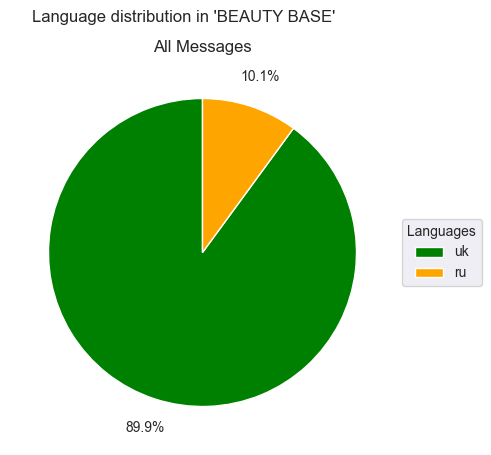

In [82]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle("Language distribution in 'BEAUTY BASE'")

get_piechart_of_language(beauty_base_df, ax=ax1, title="All Messages", add_legend=True)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

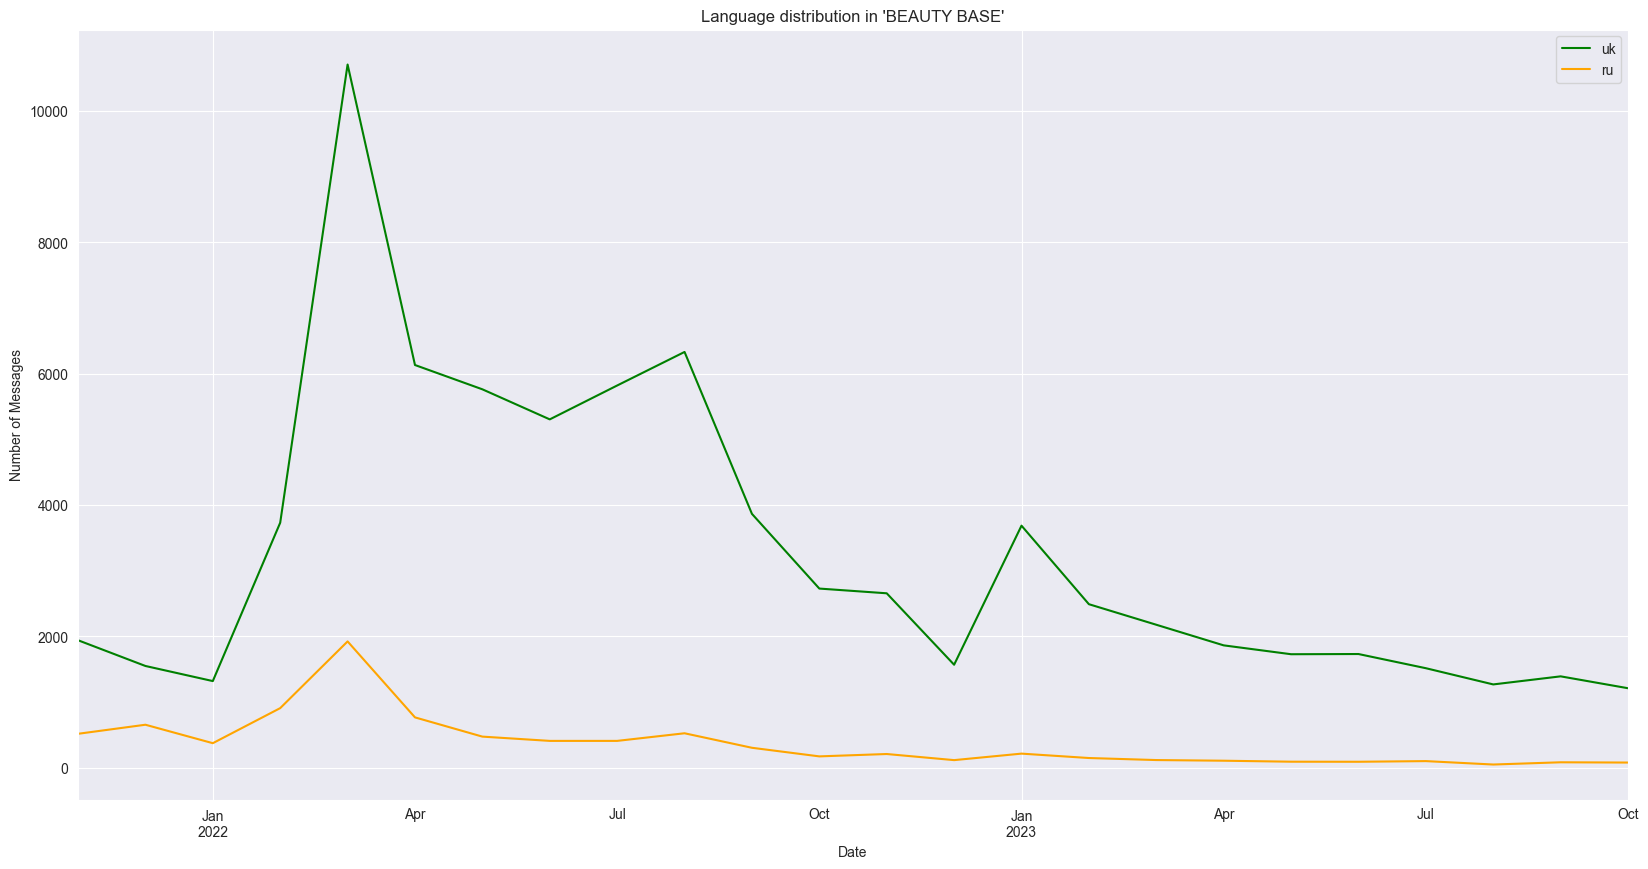

In [83]:
get_plot_of_language_per_time(beauty_base_df, "Language distribution in 'BEAUTY BASE'").show

<function matplotlib.pyplot.show(close=None, block=None)>

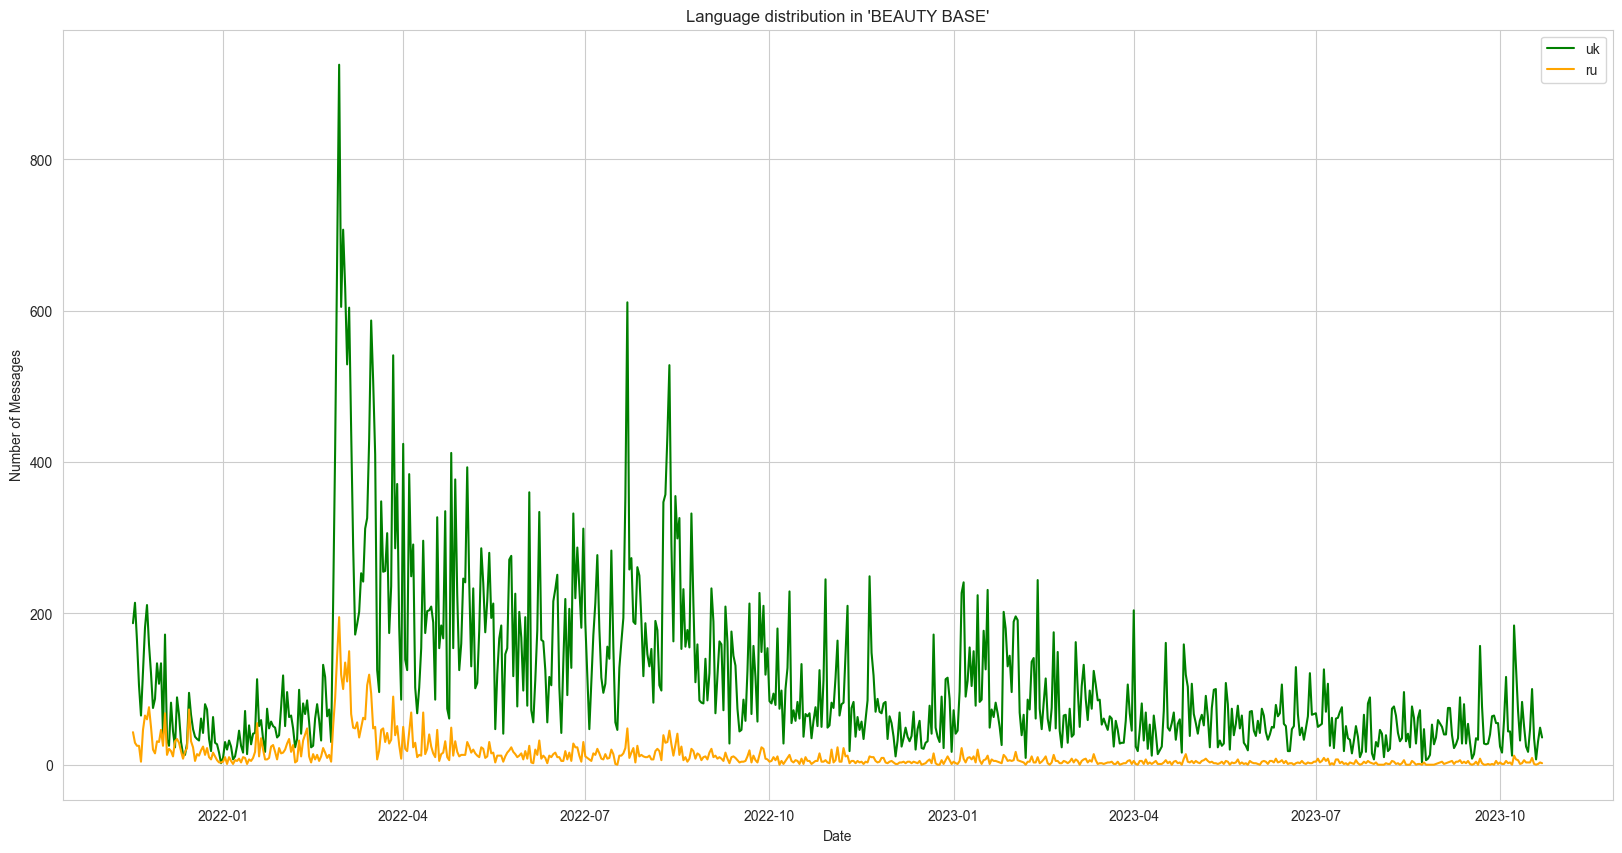

In [72]:
get_plot_of_language_per_time(beauty_base_df, "Language distribution in 'BEAUTY BASE'").show

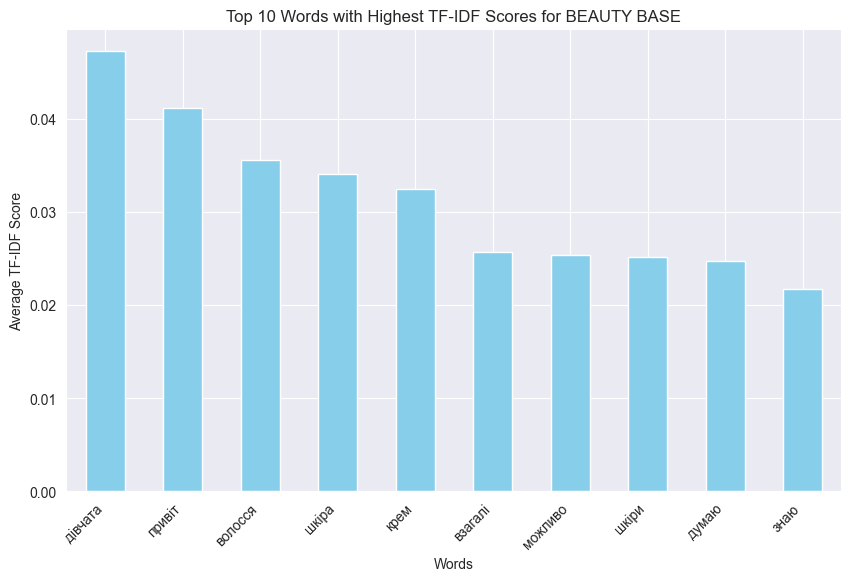

In [199]:
plt = get_top_tf_idf(beauty_base_df, 'BEAUTY BASE', 10)
plt.show()

In [209]:
channel_emoj = get_emojis_from_messages(beauty_base_df, top=10)
fig = get_top_emojis(channel_emoj, "Top-10 emojis of 'BEAUTY BASE'")
fig.show()

### Chanels analysis

In [84]:
#channels_df

In [200]:
#delete rows where dialog_id != from_id

channels_df['from_id'] = channels_df['from_id'].astype('int64')
channels_df['dialog_id'] = channels_df['dialog_id'].astype('int64')

channels_df = channels_df[channels_df['dialog_id'] == channels_df['from_id']]

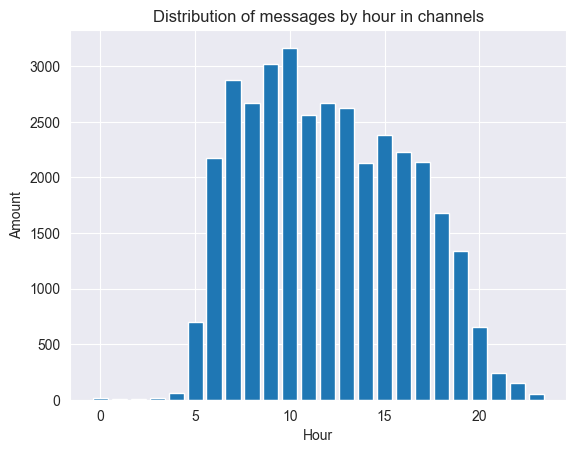

In [201]:
counts = channels_df['hour'].value_counts()
plt.bar(counts.index, counts)
plt.xlabel('Hour')
plt.ylabel('Amount')
plt.title("Distribution of messages by hour in channels")
plt.show()

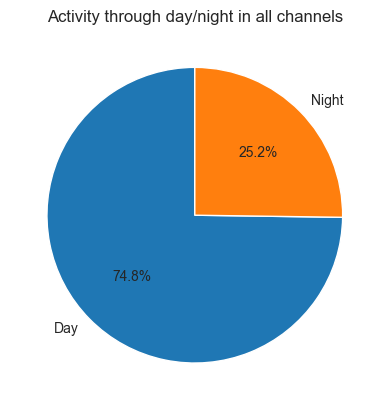

In [87]:
channels_df = get_day_night_column(channels_df)

counts = channels_df['day_night'].value_counts()
plt.pie(counts, labels = counts.index, 
        startangle = 90, autopct='%1.1f%%')
plt.title("Activity through day/night in all channels")
plt.show()

In [88]:
night_posts = channels_df[channels_df['day_night'] == 'Night']

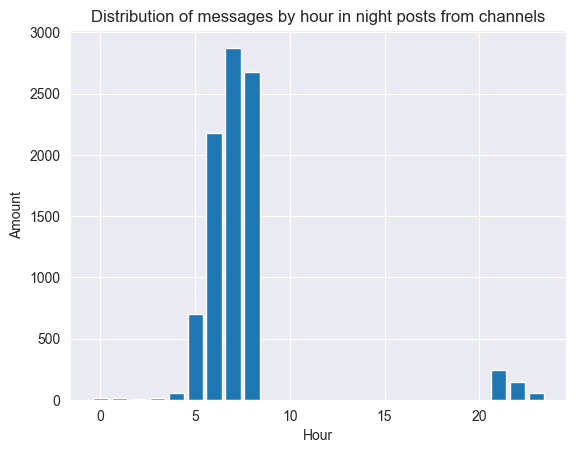

In [89]:
counts = night_posts['hour'].value_counts()
plt.bar(counts.index, counts)
plt.xlabel('Hour')
plt.ylabel('Amount')
plt.title("Distribution of messages by hour in night posts from channels")
plt.show()

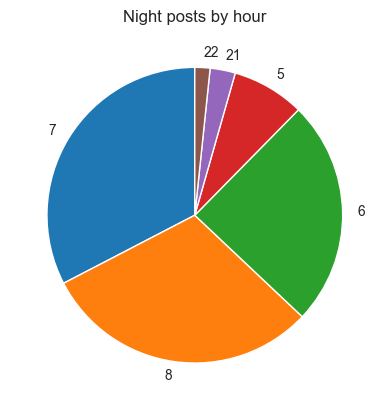

In [90]:
counts = night_posts['hour'].value_counts().head(6)
plt.pie(counts, labels = counts.index, 
        startangle = 90)
plt.title("Night posts by hour")
plt.show()

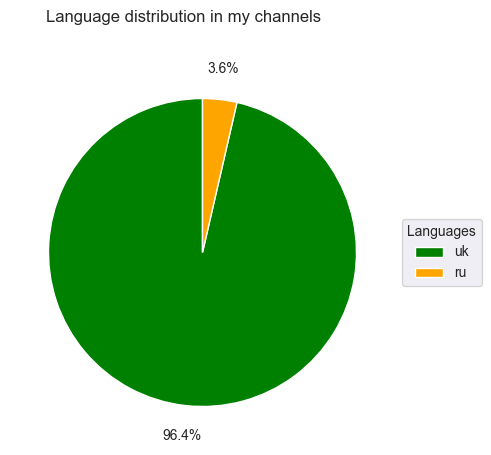

In [203]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
fig.suptitle("Language distribution in my channels")

get_piechart_of_language(channels_df, ax=ax1, add_legend=True)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

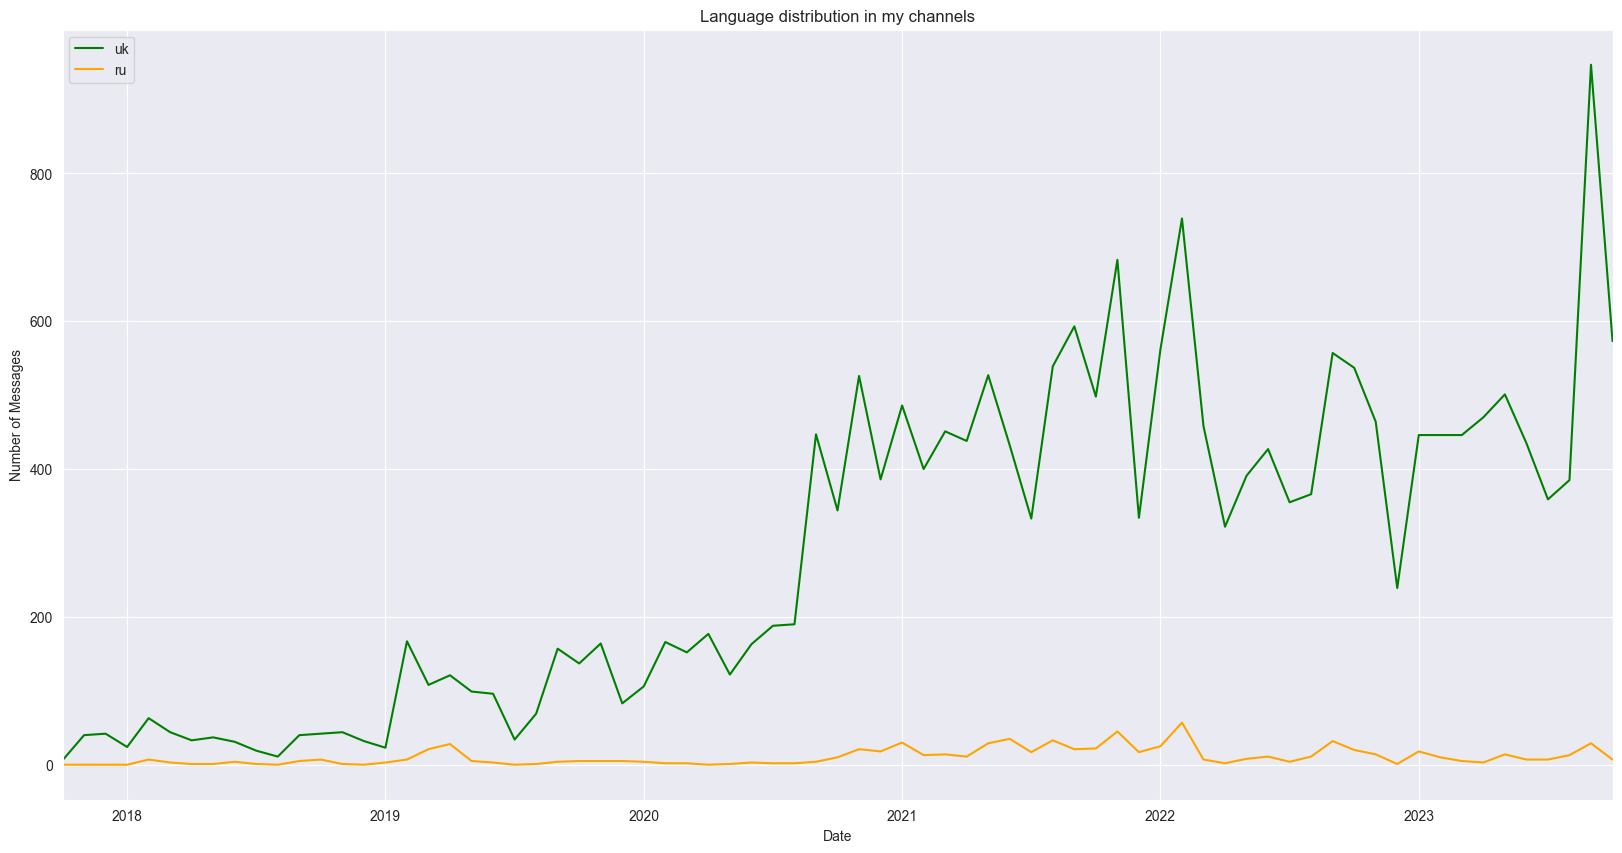

In [204]:
get_plot_of_language_per_time(channels_df, "Language distribution in my channels").show

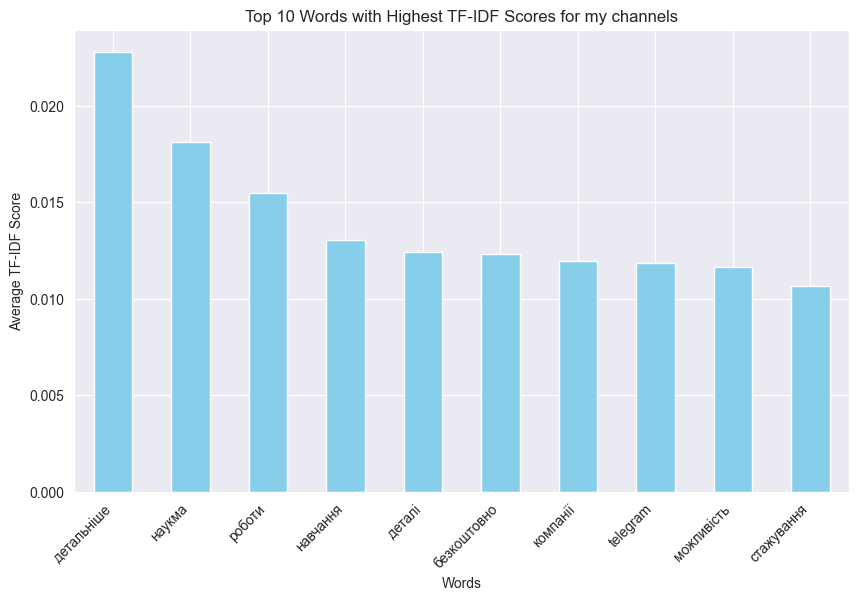

In [202]:
plt = get_top_tf_idf(channels_df, 'my channels', 10)
plt.show()

In [210]:
channel_emoj = get_emojis_from_messages(channels_df, top=10)
fig = get_top_emojis(channel_emoj, "Top-10 emojis of my channels")
fig.show()